In [2]:
import logging
# set seed
from pprint import pprint
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
import evaluation as ev
from pathlib import *
import torch
import random
import regex as re
import plot
import matplotlib.pyplot as plt
from sk_models import LocalWeightedRegression, PCR,setup_pls_models_exh,LinearRidge,CustomWrapper

In [3]:
seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)

random_state = np.random.RandomState(seed)

In [4]:
#we need to set parametesr
file_name = "mango_684_990.csv" #.csv" #"mango_684_990.csv" #"mango_729_975.csv" #fitlered=513-1050
id_cols =['Set','Season','Region','Date','Type','Cultivar','Pop','Temp','FruitID']#
output_cols = ['DM']

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/0.02")

In [5]:
data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
data = pd.read_csv(data_file)
data = ut.sample_data(data,random_state)
nrow, ncol = data.shape

n_features = ncol - 1-len(id_cols)
n_comps = [i for i in range(1,min(101,n_features))]

dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)

# todo write a summary
#ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
#tb = SummaryWriter(log_dir/"tb")
print(log_dir)

D:\workspace\lazydeep\experiments\0.02\mango_684_990


In [6]:
#todo write a summary

ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
eval = ev.MangoesSplitter(preprocessing=None,tensorboard=None,time=True,random_state=random_state)

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [7]:
def plot_preds_and_res(preds,save_loc = "", name_lambda = lambda x:x,save_lambda = lambda x:x):
    for col_name in preds.columns:
        # plot predictions
        fig, ax = plot.scatter_plot(preds,col_name,"y",color_col="set_id",title= f"Predictions for {name_lambda(col_name)}")
        plt.savefig(save_loc/f"predictions_{save_lambda(col_name)}.png",bbox_inches='tight')
        plt.close()
        # plt.show()

        fig, ax = plot.residual_plot(preds, col_name, "y", color_col="set_id",title = f"Residuals for {name_lambda(col_name)}")
        plt.savefig(save_loc/f"residuals_{save_lambda(col_name)}.png", bbox_inches='tight')
        plt.close()

In [8]:
scores_df_pls =None #datframe for scores
scores_df_pls_final =None #datframe for scores

for n_component in n_comps:
    save_loc = log_dir/f"PLS_{n_component}"
    if not save_loc.exists():
        save_loc.mkdir()
    local_logger_name = f"pls_{n_component}"
    ut.setup_logger(logger_name=local_logger_name,file_name=save_loc/f"{local_logger_name}_log.txt")
    local_logger = logging.getLogger(local_logger_name)
    local_logger.info(f"Running {n_component} components")


    #run pls
    scheme = ev.PLSScheme(n_components=n_component,scale=True,logger=local_logger_name)
    scores, preds, model_states ,train_time, test_time = eval.evaluate(setup_pls_models_exh(nrow),dataset,scheme,logger_name=local_logger_name)
    scores_pls_final, _, model_states_final , _, _= eval.build(setup_pls_models_exh(nrow),dataset,scheme,logger_name=local_logger_name)
    #for fold,nested in model_states.items():
    #    for name,model in nested.items():
    #        model.save(save_loc/(f"{name}_{fold}"))
    #for name,model in model_states_final.items():
    #    model.save(save_loc/(f"{name}_final"))

    #log results
    local_logger.info(f"Train times: {train_time}")
    local_logger.info(f"Test times: {test_time}")
    local_logger.info(f"Scores: {scores}")
    for key,value in ut.flip_dicts(scores).items():
        local_logger.info(f"{key}: {value}")

    #write preds
    preds.to_csv(save_loc/ (f"predictions_n_comp={n_component}" + ".csv"), index=False)
    #plot our figures
    plot_preds_and_res(preds,name_lambda=lambda x:f"PLS with {x} components",save_lambda= lambda x:f"pls_{x}",save_loc=save_loc)

    flipped = ut.flip_dicts(scores)
    for name,record in flipped.items():
        record1 = {'model':f"pls_{name}",'n_comp':n_component}
        if scores_df_pls is None:
            scores_df_pls =pd.DataFrame([{**record1,**record}])
        else:
            scores_df_pls=scores_df_pls.append([{**record1,**record}],ignore_index=True)
            
    flipped = ut.flip_dicts(scores_pls_final)
    for name,record in flipped.items():
        record1 = {'model':f"pls_{name}",'n_comp':n_component}
        if scores_df_pls_final is None:
            scores_df_pls_final =pd.DataFrame([{**record1,**record}])
        else:
            scores_df_pls_final=scores_df_pls_final.append([{**record1,**record}],ignore_index=True)



Running 1 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:5.2855,lwr_k=5:4.1266,lwr_k=10:4.6117,lwr_k=15:4.7835,lwr_k=20:4.874,lwr_k=25:4.9386,lwr_k=30:4.9831,lwr_k=35:5.0339,lwr_k=40:5.0489,lwr_k=45:5.0675,lwr_k=50:5.0643,lwr_k=100:5.113,lwr_k=150:5.1319,lwr_k=200:5.1592,lwr_k=250:5.1665,lwr_k=300:5.1723,lwr_k=350:5.1717,lwr_k=400:5.1707,lwr_k=450:5.1748,lwr_k=500:5.1789,lwr_k=550:5.1761,lwr_k=600:5.1754,lwr_k=650:5.177,lwr_k=700:5.1798,lwr_k=750:5.1796,lwr_k=800:5.1831,lwr_k=850:5.1843,lwr_k=900:5.1851,lwr_k=950:5.1861'
Tested (test) on 1905 instances with mean losses of: lr:5.3976,lwr_k=5:6.2379,lwr_k=10:5.6605,lwr_k=15:5.5704,lwr_k=20:5.4123,lwr_k=25:5.4149,lwr_k=30:5.3862,lwr_k=35:5.3662,lwr_k=40:5.3497,lwr_k=45:5.3658,lwr_k=50:5.3688,lwr_k=100:5.3121,lwr_k=150:5.3071,lwr_k=200:5.3033,lwr_k=250:5.2983,lwr_k=300:5.3009,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 2 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:5.2288,lwr_k=5:2.3446,lwr_k=10:3.7461,lwr_k=15:4.2184,lwr_k=20:4.4023,lwr_k=25:4.5131,lwr_k=30:4.5544,lwr_k=35:4.5889,lwr_k=40:4.607,lwr_k=45:4.6156,lwr_k=50:4.6398,lwr_k=100:4.7412,lwr_k=150:4.7855,lwr_k=200:4.8186,lwr_k=250:4.8229,lwr_k=300:4.8279,lwr_k=350:4.8351,lwr_k=400:4.8479,lwr_k=450:4.8518,lwr_k=500:4.8596,lwr_k=550:4.8648,lwr_k=600:4.871,lwr_k=650:4.8713,lwr_k=700:4.876,lwr_k=750:4.8799,lwr_k=800:4.8851,lwr_k=850:4.8927,lwr_k=900:4.8982,lwr_k=950:4.9046'
Tested (test) on 1905 instances with mean losses of: lr:5.2991,lwr_k=5:5.6689,lwr_k=10:5.1749,lwr_k=15:5.0055,lwr_k=20:4.9612,lwr_k=25:4.935,lwr_k=30:4.8828,lwr_k=35:4.8596,lwr_k=40:4.8222,lwr_k=45:4.8185,lwr_k=50:4.8071,lwr_k=100:4.7816,lwr_k=150:4.8021,lwr_k=200:4.8218,lwr_k=250:4.8216,lwr_k=300:4.8411,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 3 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:5.0751,lwr_k=5:0.8366,lwr_k=10:2.7809,lwr_k=15:3.4209,lwr_k=20:3.7312,lwr_k=25:3.8884,lwr_k=30:4.0069,lwr_k=35:4.0851,lwr_k=40:4.1533,lwr_k=45:4.1996,lwr_k=50:4.2338,lwr_k=100:4.4106,lwr_k=150:4.4736,lwr_k=200:4.5241,lwr_k=250:4.5489,lwr_k=300:4.566,lwr_k=350:4.5813,lwr_k=400:4.5979,lwr_k=450:4.6093,lwr_k=500:4.6224,lwr_k=550:4.6421,lwr_k=600:4.6569,lwr_k=650:4.6645,lwr_k=700:4.6755,lwr_k=750:4.6872,lwr_k=800:4.6981,lwr_k=850:4.7084,lwr_k=900:4.7126,lwr_k=950:4.7196'
Tested (test) on 1905 instances with mean losses of: lr:5.0659,lwr_k=5:8.0916,lwr_k=10:4.8559,lwr_k=15:4.573,lwr_k=20:4.4919,lwr_k=25:4.4287,lwr_k=30:4.4248,lwr_k=35:4.416,lwr_k=40:4.4226,lwr_k=45:4.3702,lwr_k=50:4.3873,lwr_k=100:4.4344,lwr_k=150:4.4626,lwr_k=200:4.5029,lwr_k=250:4.5049,lwr_k=300:4.5163,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 4 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:4.7223,lwr_k=5:0.2238,lwr_k=10:1.6117,lwr_k=15:2.3065,lwr_k=20:2.5864,lwr_k=25:2.7796,lwr_k=30:2.8703,lwr_k=35:2.9494,lwr_k=40:3.0003,lwr_k=45:3.0541,lwr_k=50:3.1081,lwr_k=100:3.3196,lwr_k=150:3.3942,lwr_k=200:3.4531,lwr_k=250:3.48,lwr_k=300:3.5007,lwr_k=350:3.526,lwr_k=400:3.5431,lwr_k=450:3.5634,lwr_k=500:3.5897,lwr_k=550:3.6075,lwr_k=600:3.6223,lwr_k=650:3.6409,lwr_k=700:3.6608,lwr_k=750:3.6803,lwr_k=800:3.6992,lwr_k=850:3.7195,lwr_k=900:3.7333,lwr_k=950:3.7466'
Tested (test) on 1905 instances with mean losses of: lr:4.8002,lwr_k=5:4.9403,lwr_k=10:4.1679,lwr_k=15:3.565,lwr_k=20:3.4474,lwr_k=25:3.4317,lwr_k=30:3.4425,lwr_k=35:3.4552,lwr_k=40:3.4434,lwr_k=45:3.4743,lwr_k=50:3.4743,lwr_k=100:3.5292,lwr_k=150:3.5563,lwr_k=200:3.5944,lwr_k=250:3.6151,lwr_k=300:3.6331,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 5 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:3.7266,lwr_k=5:0.0799,lwr_k=10:0.946,lwr_k=15:1.611,lwr_k=20:1.8868,lwr_k=25:2.0779,lwr_k=30:2.1966,lwr_k=35:2.2879,lwr_k=40:2.3497,lwr_k=45:2.4022,lwr_k=50:2.4498,lwr_k=100:2.6886,lwr_k=150:2.7768,lwr_k=200:2.8239,lwr_k=250:2.8646,lwr_k=300:2.8939,lwr_k=350:2.917,lwr_k=400:2.939,lwr_k=450:2.9641,lwr_k=500:2.9851,lwr_k=550:3.0091,lwr_k=600:3.0264,lwr_k=650:3.0464,lwr_k=700:3.0656,lwr_k=750:3.0811,lwr_k=800:3.1006,lwr_k=850:3.1216,lwr_k=900:3.1344,lwr_k=950:3.1477'
Tested (test) on 1905 instances with mean losses of: lr:3.7157,lwr_k=5:4.1104,lwr_k=10:4.3105,lwr_k=15:3.2271,lwr_k=20:3.092,lwr_k=25:2.9898,lwr_k=30:2.9059,lwr_k=35:2.9256,lwr_k=40:2.8886,lwr_k=45:2.8849,lwr_k=50:2.8762,lwr_k=100:2.8856,lwr_k=150:2.9319,lwr_k=200:2.9533,lwr_k=250:2.9911,lwr_k=300:2.9923,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 6 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:2.7844,lwr_k=5:0.0385,lwr_k=10:0.4414,lwr_k=15:0.9028,lwr_k=20:1.1569,lwr_k=25:1.3352,lwr_k=30:1.4434,lwr_k=35:1.5334,lwr_k=40:1.5963,lwr_k=45:1.6445,lwr_k=50:1.6864,lwr_k=100:1.8994,lwr_k=150:1.9939,lwr_k=200:2.0476,lwr_k=250:2.0922,lwr_k=300:2.1204,lwr_k=350:2.1395,lwr_k=400:2.1592,lwr_k=450:2.1809,lwr_k=500:2.1986,lwr_k=550:2.212,lwr_k=600:2.2265,lwr_k=650:2.2406,lwr_k=700:2.2518,lwr_k=750:2.262,lwr_k=800:2.2721,lwr_k=850:2.2838,lwr_k=900:2.2898,lwr_k=950:2.2981'
Tested (test) on 1905 instances with mean losses of: lr:2.8257,lwr_k=5:2.972,lwr_k=10:3.4038,lwr_k=15:2.5172,lwr_k=20:2.3721,lwr_k=25:2.2615,lwr_k=30:2.2201,lwr_k=35:2.2064,lwr_k=40:2.173,lwr_k=45:2.1711,lwr_k=50:2.1756,lwr_k=100:2.1679,lwr_k=150:2.2148,lwr_k=200:2.2108,lwr_k=250:2.2502,lwr_k=300:2.2542,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 7 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:2.5206,lwr_k=5:0.0219,lwr_k=10:0.2458,lwr_k=15:0.6388,lwr_k=20:0.9035,lwr_k=25:1.0817,lwr_k=30:1.1952,lwr_k=35:1.2929,lwr_k=40:1.3695,lwr_k=45:1.4296,lwr_k=50:1.4788,lwr_k=100:1.7058,lwr_k=150:1.82,lwr_k=200:1.8888,lwr_k=250:1.9346,lwr_k=300:1.9676,lwr_k=350:1.992,lwr_k=400:2.0097,lwr_k=450:2.0281,lwr_k=500:2.0434,lwr_k=550:2.0594,lwr_k=600:2.0725,lwr_k=650:2.0864,lwr_k=700:2.0974,lwr_k=750:2.1084,lwr_k=800:2.119,lwr_k=850:2.1294,lwr_k=900:2.1356,lwr_k=950:2.1424'
Tested (test) on 1905 instances with mean losses of: lr:2.5519,lwr_k=5:2.5042,lwr_k=10:3.3534,lwr_k=15:2.3626,lwr_k=20:2.1201,lwr_k=25:2.0626,lwr_k=30:1.996,lwr_k=35:2.0083,lwr_k=40:2.0052,lwr_k=45:2.0068,lwr_k=50:2.005,lwr_k=100:2.0019,lwr_k=150:2.0475,lwr_k=200:2.06,lwr_k=250:2.0769,lwr_k=300:2.0943,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 8 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:1.2334,lwr_k=5:0.0135,lwr_k=10:0.0978,lwr_k=15:0.2591,lwr_k=20:0.3716,lwr_k=25:0.4493,lwr_k=30:0.5087,lwr_k=35:0.5511,lwr_k=40:0.5811,lwr_k=45:0.6049,lwr_k=50:0.6245,lwr_k=100:0.7375,lwr_k=150:0.7865,lwr_k=200:0.8103,lwr_k=250:0.8296,lwr_k=300:0.8461,lwr_k=350:0.8542,lwr_k=400:0.8611,lwr_k=450:0.8676,lwr_k=500:0.8741,lwr_k=550:0.8816,lwr_k=600:0.8885,lwr_k=650:0.8937,lwr_k=700:0.8995,lwr_k=750:0.9032,lwr_k=800:0.9077,lwr_k=850:0.9132,lwr_k=900:0.9161,lwr_k=950:0.9214'
Tested (test) on 1905 instances with mean losses of: lr:1.2381,lwr_k=5:2.1167,lwr_k=10:1.7001,lwr_k=15:1.2198,lwr_k=20:1.0359,lwr_k=25:0.9531,lwr_k=30:0.9199,lwr_k=35:0.8991,lwr_k=40:0.8855,lwr_k=45:0.8845,lwr_k=50:0.8736,lwr_k=100:0.8448,lwr_k=150:0.8494,lwr_k=200:0.8559,lwr_k=250:0.8653,lwr_k=300:0.872,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 9 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.9928,lwr_k=5:0.0129,lwr_k=10:0.087,lwr_k=15:0.226,lwr_k=20:0.3272,lwr_k=25:0.3998,lwr_k=30:0.4582,lwr_k=35:0.4977,lwr_k=40:0.5282,lwr_k=45:0.5511,lwr_k=50:0.5718,lwr_k=100:0.6929,lwr_k=150:0.7421,lwr_k=200:0.7685,lwr_k=250:0.79,lwr_k=300:0.8064,lwr_k=350:0.8155,lwr_k=400:0.8239,lwr_k=450:0.8306,lwr_k=500:0.838,lwr_k=550:0.8459,lwr_k=600:0.8535,lwr_k=650:0.8586,lwr_k=700:0.8642,lwr_k=750:0.8682,lwr_k=800:0.8732,lwr_k=850:0.878,lwr_k=900:0.8806,lwr_k=950:0.8847'
Tested (test) on 1905 instances with mean losses of: lr:1.0004,lwr_k=5:2.0753,lwr_k=10:1.5927,lwr_k=15:1.1735,lwr_k=20:1.0208,lwr_k=25:0.9231,lwr_k=30:0.8909,lwr_k=35:0.8731,lwr_k=40:0.8639,lwr_k=45:0.8652,lwr_k=50:0.8482,lwr_k=100:0.8226,lwr_k=150:0.8305,lwr_k=200:0.8353,lwr_k=250:0.8417,lwr_k=300:0.846,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 10 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8635,lwr_k=5:0.0114,lwr_k=10:0.0662,lwr_k=15:0.1554,lwr_k=20:0.2299,lwr_k=25:0.2902,lwr_k=30:0.3397,lwr_k=35:0.3767,lwr_k=40:0.4044,lwr_k=45:0.4289,lwr_k=50:0.4485,lwr_k=100:0.5631,lwr_k=150:0.6112,lwr_k=200:0.6411,lwr_k=250:0.6621,lwr_k=300:0.6764,lwr_k=350:0.6853,lwr_k=400:0.695,lwr_k=450:0.7023,lwr_k=500:0.7098,lwr_k=550:0.7167,lwr_k=600:0.723,lwr_k=650:0.7277,lwr_k=700:0.7316,lwr_k=750:0.7367,lwr_k=800:0.7406,lwr_k=850:0.7456,lwr_k=900:0.7487,lwr_k=950:0.7537'
Tested (test) on 1905 instances with mean losses of: lr:0.8613,lwr_k=5:2.0319,lwr_k=10:1.4391,lwr_k=15:1.0255,lwr_k=20:0.9095,lwr_k=25:0.8105,lwr_k=30:0.7753,lwr_k=35:0.7418,lwr_k=40:0.7292,lwr_k=45:0.7254,lwr_k=50:0.7106,lwr_k=100:0.6931,lwr_k=150:0.705,lwr_k=200:0.7142,lwr_k=250:0.7172,lwr_k=300:0.7233,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 11 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.8248,lwr_k=5:0.0111,lwr_k=10:0.0628,lwr_k=15:0.1442,lwr_k=20:0.2099,lwr_k=25:0.2658,lwr_k=30:0.3108,lwr_k=35:0.3443,lwr_k=40:0.3712,lwr_k=45:0.3932,lwr_k=50:0.4121,lwr_k=100:0.5198,lwr_k=150:0.5654,lwr_k=200:0.5921,lwr_k=250:0.6118,lwr_k=300:0.6258,lwr_k=350:0.6349,lwr_k=400:0.6435,lwr_k=450:0.6499,lwr_k=500:0.656,lwr_k=550:0.6619,lwr_k=600:0.6669,lwr_k=650:0.6715,lwr_k=700:0.675,lwr_k=750:0.6788,lwr_k=800:0.6833,lwr_k=850:0.6872,lwr_k=900:0.6891,lwr_k=950:0.6931'
Tested (test) on 1905 instances with mean losses of: lr:0.8273,lwr_k=5:2.025,lwr_k=10:1.4133,lwr_k=15:1.0126,lwr_k=20:0.8782,lwr_k=25:0.7831,lwr_k=30:0.7518,lwr_k=35:0.7188,lwr_k=40:0.704,lwr_k=45:0.6977,lwr_k=50:0.6827,lwr_k=100:0.6637,lwr_k=150:0.6754,lwr_k=200:0.6788,lwr_k=250:0.6767,lwr_k=300:0.6802,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 12 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7986,lwr_k=5:0.011,lwr_k=10:0.0614,lwr_k=15:0.1395,lwr_k=20:0.2002,lwr_k=25:0.2509,lwr_k=30:0.2916,lwr_k=35:0.3215,lwr_k=40:0.3446,lwr_k=45:0.3637,lwr_k=50:0.3803,lwr_k=100:0.4742,lwr_k=150:0.5142,lwr_k=200:0.5399,lwr_k=250:0.5581,lwr_k=300:0.5722,lwr_k=350:0.5807,lwr_k=400:0.589,lwr_k=450:0.5947,lwr_k=500:0.6007,lwr_k=550:0.6071,lwr_k=600:0.6115,lwr_k=650:0.616,lwr_k=700:0.6199,lwr_k=750:0.6243,lwr_k=800:0.629,lwr_k=850:0.633,lwr_k=900:0.6359,lwr_k=950:0.6403'
Tested (test) on 1905 instances with mean losses of: lr:0.8097,lwr_k=5:2.024,lwr_k=10:1.411,lwr_k=15:1.0029,lwr_k=20:0.8679,lwr_k=25:0.7692,lwr_k=30:0.7303,lwr_k=35:0.6933,lwr_k=40:0.6769,lwr_k=45:0.6679,lwr_k=50:0.6495,lwr_k=100:0.6244,lwr_k=150:0.6332,lwr_k=200:0.6399,lwr_k=250:0.6418,lwr_k=300:0.6444,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 13 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7882,lwr_k=5:0.0109,lwr_k=10:0.0601,lwr_k=15:0.1346,lwr_k=20:0.1925,lwr_k=25:0.2413,lwr_k=30:0.2792,lwr_k=35:0.3083,lwr_k=40:0.3297,lwr_k=45:0.3476,lwr_k=50:0.3634,lwr_k=100:0.4587,lwr_k=150:0.5003,lwr_k=200:0.5249,lwr_k=250:0.5427,lwr_k=300:0.5573,lwr_k=350:0.5657,lwr_k=400:0.5733,lwr_k=450:0.5793,lwr_k=500:0.5853,lwr_k=550:0.5924,lwr_k=600:0.5969,lwr_k=650:0.602,lwr_k=700:0.6061,lwr_k=750:0.611,lwr_k=800:0.6157,lwr_k=850:0.6197,lwr_k=900:0.6228,lwr_k=950:0.6273'
Tested (test) on 1905 instances with mean losses of: lr:0.7959,lwr_k=5:2.0217,lwr_k=10:1.4109,lwr_k=15:0.9945,lwr_k=20:0.8595,lwr_k=25:0.7605,lwr_k=30:0.7203,lwr_k=35:0.6794,lwr_k=40:0.6619,lwr_k=45:0.6553,lwr_k=50:0.6392,lwr_k=100:0.6087,lwr_k=150:0.6193,lwr_k=200:0.6217,lwr_k=250:0.6215,lwr_k=300:0.6276,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 14 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.773,lwr_k=5:0.0108,lwr_k=10:0.0589,lwr_k=15:0.131,lwr_k=20:0.1867,lwr_k=25:0.2326,lwr_k=30:0.2687,lwr_k=35:0.2961,lwr_k=40:0.3168,lwr_k=45:0.3336,lwr_k=50:0.3498,lwr_k=100:0.4409,lwr_k=150:0.4816,lwr_k=200:0.5068,lwr_k=250:0.525,lwr_k=300:0.5402,lwr_k=350:0.5482,lwr_k=400:0.5557,lwr_k=450:0.5619,lwr_k=500:0.5682,lwr_k=550:0.575,lwr_k=600:0.5795,lwr_k=650:0.5846,lwr_k=700:0.5889,lwr_k=750:0.5937,lwr_k=800:0.5989,lwr_k=850:0.6031,lwr_k=900:0.6063,lwr_k=950:0.6108'
Tested (test) on 1905 instances with mean losses of: lr:0.7859,lwr_k=5:2.0161,lwr_k=10:1.4028,lwr_k=15:0.9888,lwr_k=20:0.851,lwr_k=25:0.7516,lwr_k=30:0.7081,lwr_k=35:0.6672,lwr_k=40:0.6484,lwr_k=45:0.6417,lwr_k=50:0.6272,lwr_k=100:0.5939,lwr_k=150:0.6058,lwr_k=200:0.6129,lwr_k=250:0.6122,lwr_k=300:0.6184,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 15 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7589,lwr_k=5:0.0106,lwr_k=10:0.057,lwr_k=15:0.1264,lwr_k=20:0.1796,lwr_k=25:0.2235,lwr_k=30:0.2581,lwr_k=35:0.285,lwr_k=40:0.3054,lwr_k=45:0.3215,lwr_k=50:0.3377,lwr_k=100:0.426,lwr_k=150:0.4676,lwr_k=200:0.4928,lwr_k=250:0.511,lwr_k=300:0.5265,lwr_k=350:0.5343,lwr_k=400:0.5421,lwr_k=450:0.5487,lwr_k=500:0.5552,lwr_k=550:0.562,lwr_k=600:0.5669,lwr_k=650:0.5721,lwr_k=700:0.5763,lwr_k=750:0.5808,lwr_k=800:0.5859,lwr_k=850:0.5901,lwr_k=900:0.5929,lwr_k=950:0.5974'
Tested (test) on 1905 instances with mean losses of: lr:0.766,lwr_k=5:2.0144,lwr_k=10:1.3977,lwr_k=15:0.9867,lwr_k=20:0.8384,lwr_k=25:0.7439,lwr_k=30:0.7008,lwr_k=35:0.662,lwr_k=40:0.6381,lwr_k=45:0.6269,lwr_k=50:0.6136,lwr_k=100:0.5793,lwr_k=150:0.5877,lwr_k=200:0.5963,lwr_k=250:0.5967,lwr_k=300:0.6035,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 16 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7496,lwr_k=5:0.0105,lwr_k=10:0.0557,lwr_k=15:0.1227,lwr_k=20:0.1738,lwr_k=25:0.217,lwr_k=30:0.251,lwr_k=35:0.2779,lwr_k=40:0.2981,lwr_k=45:0.3136,lwr_k=50:0.3301,lwr_k=100:0.4187,lwr_k=150:0.4599,lwr_k=200:0.4849,lwr_k=250:0.503,lwr_k=300:0.5184,lwr_k=350:0.527,lwr_k=400:0.5354,lwr_k=450:0.5422,lwr_k=500:0.5486,lwr_k=550:0.5557,lwr_k=600:0.5608,lwr_k=650:0.5662,lwr_k=700:0.5709,lwr_k=750:0.575,lwr_k=800:0.5802,lwr_k=850:0.5841,lwr_k=900:0.5869,lwr_k=950:0.5914'
Tested (test) on 1905 instances with mean losses of: lr:0.7621,lwr_k=5:2.0118,lwr_k=10:1.4014,lwr_k=15:0.9798,lwr_k=20:0.8364,lwr_k=25:0.7523,lwr_k=30:0.7067,lwr_k=35:0.6656,lwr_k=40:0.6406,lwr_k=45:0.6276,lwr_k=50:0.613,lwr_k=100:0.5789,lwr_k=150:0.5859,lwr_k=200:0.5953,lwr_k=250:0.595,lwr_k=300:0.6023,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 17 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7459,lwr_k=5:0.0104,lwr_k=10:0.0541,lwr_k=15:0.1183,lwr_k=20:0.1678,lwr_k=25:0.2099,lwr_k=30:0.2436,lwr_k=35:0.2698,lwr_k=40:0.2901,lwr_k=45:0.3061,lwr_k=50:0.3222,lwr_k=100:0.4109,lwr_k=150:0.453,lwr_k=200:0.4787,lwr_k=250:0.4985,lwr_k=300:0.5151,lwr_k=350:0.5231,lwr_k=400:0.5315,lwr_k=450:0.5378,lwr_k=500:0.5444,lwr_k=550:0.5509,lwr_k=600:0.5562,lwr_k=650:0.5616,lwr_k=700:0.5664,lwr_k=750:0.5702,lwr_k=800:0.575,lwr_k=850:0.5787,lwr_k=900:0.5814,lwr_k=950:0.5858'
Tested (test) on 1905 instances with mean losses of: lr:0.7598,lwr_k=5:2.0097,lwr_k=10:1.3779,lwr_k=15:0.9748,lwr_k=20:0.8394,lwr_k=25:0.757,lwr_k=30:0.7107,lwr_k=35:0.6664,lwr_k=40:0.6447,lwr_k=45:0.6329,lwr_k=50:0.6187,lwr_k=100:0.5835,lwr_k=150:0.588,lwr_k=200:0.598,lwr_k=250:0.5965,lwr_k=300:0.603,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 18 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7411,lwr_k=5:0.0103,lwr_k=10:0.0531,lwr_k=15:0.116,lwr_k=20:0.1645,lwr_k=25:0.2059,lwr_k=30:0.2392,lwr_k=35:0.265,lwr_k=40:0.2851,lwr_k=45:0.301,lwr_k=50:0.3168,lwr_k=100:0.4054,lwr_k=150:0.4476,lwr_k=200:0.4735,lwr_k=250:0.4945,lwr_k=300:0.512,lwr_k=350:0.5198,lwr_k=400:0.5281,lwr_k=450:0.5347,lwr_k=500:0.5413,lwr_k=550:0.5481,lwr_k=600:0.5535,lwr_k=650:0.5588,lwr_k=700:0.5635,lwr_k=750:0.5674,lwr_k=800:0.5723,lwr_k=850:0.5759,lwr_k=900:0.5786,lwr_k=950:0.5827'
Tested (test) on 1905 instances with mean losses of: lr:0.7497,lwr_k=5:2.0096,lwr_k=10:1.3772,lwr_k=15:0.974,lwr_k=20:0.8394,lwr_k=25:0.759,lwr_k=30:0.712,lwr_k=35:0.6675,lwr_k=40:0.6438,lwr_k=45:0.6339,lwr_k=50:0.6187,lwr_k=100:0.5826,lwr_k=150:0.5869,lwr_k=200:0.5957,lwr_k=250:0.5937,lwr_k=300:0.5987,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 19 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7336,lwr_k=5:0.0102,lwr_k=10:0.0524,lwr_k=15:0.1139,lwr_k=20:0.1608,lwr_k=25:0.2014,lwr_k=30:0.2343,lwr_k=35:0.2594,lwr_k=40:0.279,lwr_k=45:0.2946,lwr_k=50:0.3103,lwr_k=100:0.3983,lwr_k=150:0.4411,lwr_k=200:0.4669,lwr_k=250:0.4873,lwr_k=300:0.5046,lwr_k=350:0.513,lwr_k=400:0.521,lwr_k=450:0.5278,lwr_k=500:0.5345,lwr_k=550:0.5413,lwr_k=600:0.5461,lwr_k=650:0.5513,lwr_k=700:0.5563,lwr_k=750:0.5606,lwr_k=800:0.5657,lwr_k=850:0.5693,lwr_k=900:0.5722,lwr_k=950:0.5761'
Tested (test) on 1905 instances with mean losses of: lr:0.733,lwr_k=5:2.0071,lwr_k=10:1.3795,lwr_k=15:0.9741,lwr_k=20:0.8366,lwr_k=25:0.7563,lwr_k=30:0.7086,lwr_k=35:0.6635,lwr_k=40:0.6406,lwr_k=45:0.6314,lwr_k=50:0.6152,lwr_k=100:0.5749,lwr_k=150:0.5822,lwr_k=200:0.5887,lwr_k=250:0.5861,lwr_k=300:0.591,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 20 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7298,lwr_k=5:0.01,lwr_k=10:0.051,lwr_k=15:0.1104,lwr_k=20:0.1559,lwr_k=25:0.1958,lwr_k=30:0.2282,lwr_k=35:0.2535,lwr_k=40:0.2729,lwr_k=45:0.2887,lwr_k=50:0.3041,lwr_k=100:0.3898,lwr_k=150:0.4339,lwr_k=200:0.4598,lwr_k=250:0.4791,lwr_k=300:0.496,lwr_k=350:0.5054,lwr_k=400:0.5134,lwr_k=450:0.5202,lwr_k=500:0.5272,lwr_k=550:0.5337,lwr_k=600:0.5382,lwr_k=650:0.5434,lwr_k=700:0.5486,lwr_k=750:0.5529,lwr_k=800:0.5582,lwr_k=850:0.5618,lwr_k=900:0.5648,lwr_k=950:0.5686'
Tested (test) on 1905 instances with mean losses of: lr:0.7278,lwr_k=5:2.0017,lwr_k=10:1.3794,lwr_k=15:0.9708,lwr_k=20:0.8371,lwr_k=25:0.756,lwr_k=30:0.7057,lwr_k=35:0.6626,lwr_k=40:0.64,lwr_k=45:0.6295,lwr_k=50:0.6103,lwr_k=100:0.569,lwr_k=150:0.5762,lwr_k=200:0.583,lwr_k=250:0.5796,lwr_k=300:0.5846,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 21 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7271,lwr_k=5:0.0099,lwr_k=10:0.0498,lwr_k=15:0.107,lwr_k=20:0.152,lwr_k=25:0.1899,lwr_k=30:0.2222,lwr_k=35:0.2464,lwr_k=40:0.2653,lwr_k=45:0.2815,lwr_k=50:0.2967,lwr_k=100:0.383,lwr_k=150:0.429,lwr_k=200:0.4556,lwr_k=250:0.4754,lwr_k=300:0.4917,lwr_k=350:0.5012,lwr_k=400:0.5098,lwr_k=450:0.5169,lwr_k=500:0.5243,lwr_k=550:0.531,lwr_k=600:0.5354,lwr_k=650:0.5411,lwr_k=700:0.5463,lwr_k=750:0.5507,lwr_k=800:0.556,lwr_k=850:0.5598,lwr_k=900:0.5629,lwr_k=950:0.5667'
Tested (test) on 1905 instances with mean losses of: lr:0.7264,lwr_k=5:1.9966,lwr_k=10:1.373,lwr_k=15:0.9767,lwr_k=20:0.8351,lwr_k=25:0.7528,lwr_k=30:0.7039,lwr_k=35:0.663,lwr_k=40:0.6402,lwr_k=45:0.6292,lwr_k=50:0.6119,lwr_k=100:0.566,lwr_k=150:0.5778,lwr_k=200:0.5818,lwr_k=250:0.5784,lwr_k=300:0.5835,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 22 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7241,lwr_k=5:0.0098,lwr_k=10:0.0491,lwr_k=15:0.1052,lwr_k=20:0.1494,lwr_k=25:0.1872,lwr_k=30:0.2189,lwr_k=35:0.2426,lwr_k=40:0.2614,lwr_k=45:0.2771,lwr_k=50:0.2919,lwr_k=100:0.3796,lwr_k=150:0.4254,lwr_k=200:0.4523,lwr_k=250:0.4728,lwr_k=300:0.4892,lwr_k=350:0.4989,lwr_k=400:0.508,lwr_k=450:0.5153,lwr_k=500:0.5229,lwr_k=550:0.5294,lwr_k=600:0.5338,lwr_k=650:0.5397,lwr_k=700:0.5449,lwr_k=750:0.5491,lwr_k=800:0.5546,lwr_k=850:0.5583,lwr_k=900:0.5613,lwr_k=950:0.5653'
Tested (test) on 1905 instances with mean losses of: lr:0.7232,lwr_k=5:1.9965,lwr_k=10:1.371,lwr_k=15:0.9792,lwr_k=20:0.8355,lwr_k=25:0.7545,lwr_k=30:0.7051,lwr_k=35:0.6644,lwr_k=40:0.6423,lwr_k=45:0.6302,lwr_k=50:0.6136,lwr_k=100:0.5671,lwr_k=150:0.5788,lwr_k=200:0.5812,lwr_k=250:0.5785,lwr_k=300:0.5845,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 23 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7216,lwr_k=5:0.0097,lwr_k=10:0.0487,lwr_k=15:0.1039,lwr_k=20:0.1472,lwr_k=25:0.1844,lwr_k=30:0.2157,lwr_k=35:0.2392,lwr_k=40:0.2576,lwr_k=45:0.2734,lwr_k=50:0.2879,lwr_k=100:0.375,lwr_k=150:0.4211,lwr_k=200:0.4487,lwr_k=250:0.4699,lwr_k=300:0.4866,lwr_k=350:0.4964,lwr_k=400:0.5054,lwr_k=450:0.5129,lwr_k=500:0.5208,lwr_k=550:0.5278,lwr_k=600:0.5322,lwr_k=650:0.5382,lwr_k=700:0.5433,lwr_k=750:0.5475,lwr_k=800:0.5531,lwr_k=850:0.5567,lwr_k=900:0.56,lwr_k=950:0.5638'
Tested (test) on 1905 instances with mean losses of: lr:0.722,lwr_k=5:1.9974,lwr_k=10:1.369,lwr_k=15:0.9759,lwr_k=20:0.8336,lwr_k=25:0.756,lwr_k=30:0.7055,lwr_k=35:0.6638,lwr_k=40:0.6424,lwr_k=45:0.6311,lwr_k=50:0.6141,lwr_k=100:0.5674,lwr_k=150:0.5794,lwr_k=200:0.5815,lwr_k=250:0.5789,lwr_k=300:0.5853,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 24 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7198,lwr_k=5:0.0097,lwr_k=10:0.0478,lwr_k=15:0.1018,lwr_k=20:0.1443,lwr_k=25:0.1803,lwr_k=30:0.2109,lwr_k=35:0.2343,lwr_k=40:0.2529,lwr_k=45:0.2684,lwr_k=50:0.2833,lwr_k=100:0.371,lwr_k=150:0.4177,lwr_k=200:0.445,lwr_k=250:0.4659,lwr_k=300:0.483,lwr_k=350:0.493,lwr_k=400:0.5025,lwr_k=450:0.51,lwr_k=500:0.5181,lwr_k=550:0.5254,lwr_k=600:0.53,lwr_k=650:0.5364,lwr_k=700:0.5418,lwr_k=750:0.5461,lwr_k=800:0.5516,lwr_k=850:0.5553,lwr_k=900:0.5585,lwr_k=950:0.5624'
Tested (test) on 1905 instances with mean losses of: lr:0.7214,lwr_k=5:1.9956,lwr_k=10:1.3672,lwr_k=15:0.9772,lwr_k=20:0.8333,lwr_k=25:0.7558,lwr_k=30:0.7018,lwr_k=35:0.6618,lwr_k=40:0.6407,lwr_k=45:0.6312,lwr_k=50:0.6145,lwr_k=100:0.5681,lwr_k=150:0.5811,lwr_k=200:0.5809,lwr_k=250:0.5785,lwr_k=300:0.585,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 25 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7168,lwr_k=5:0.0096,lwr_k=10:0.0476,lwr_k=15:0.1014,lwr_k=20:0.1436,lwr_k=25:0.1793,lwr_k=30:0.2097,lwr_k=35:0.233,lwr_k=40:0.2515,lwr_k=45:0.2668,lwr_k=50:0.2814,lwr_k=100:0.3684,lwr_k=150:0.4154,lwr_k=200:0.4425,lwr_k=250:0.4629,lwr_k=300:0.4803,lwr_k=350:0.4901,lwr_k=400:0.4996,lwr_k=450:0.5072,lwr_k=500:0.5155,lwr_k=550:0.5229,lwr_k=600:0.528,lwr_k=650:0.5345,lwr_k=700:0.5397,lwr_k=750:0.544,lwr_k=800:0.5496,lwr_k=850:0.5534,lwr_k=900:0.5567,lwr_k=950:0.5606'
Tested (test) on 1905 instances with mean losses of: lr:0.7176,lwr_k=5:1.9955,lwr_k=10:1.3672,lwr_k=15:0.9777,lwr_k=20:0.8334,lwr_k=25:0.7563,lwr_k=30:0.7023,lwr_k=35:0.6623,lwr_k=40:0.6408,lwr_k=45:0.6314,lwr_k=50:0.6144,lwr_k=100:0.5683,lwr_k=150:0.5812,lwr_k=200:0.5811,lwr_k=250:0.5783,lwr_k=300:0.5839,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 26 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7143,lwr_k=5:0.0096,lwr_k=10:0.0474,lwr_k=15:0.1009,lwr_k=20:0.1427,lwr_k=25:0.1782,lwr_k=30:0.2084,lwr_k=35:0.2314,lwr_k=40:0.2498,lwr_k=45:0.2651,lwr_k=50:0.2796,lwr_k=100:0.3658,lwr_k=150:0.4126,lwr_k=200:0.4401,lwr_k=250:0.4602,lwr_k=300:0.4777,lwr_k=350:0.4875,lwr_k=400:0.4966,lwr_k=450:0.5044,lwr_k=500:0.5124,lwr_k=550:0.5197,lwr_k=600:0.525,lwr_k=650:0.5317,lwr_k=700:0.5367,lwr_k=750:0.5411,lwr_k=800:0.5467,lwr_k=850:0.5506,lwr_k=900:0.5538,lwr_k=950:0.5578'
Tested (test) on 1905 instances with mean losses of: lr:0.714,lwr_k=5:1.9953,lwr_k=10:1.3666,lwr_k=15:0.9777,lwr_k=20:0.8333,lwr_k=25:0.7557,lwr_k=30:0.7026,lwr_k=35:0.6627,lwr_k=40:0.6412,lwr_k=45:0.6315,lwr_k=50:0.6144,lwr_k=100:0.5674,lwr_k=150:0.579,lwr_k=200:0.5777,lwr_k=250:0.576,lwr_k=300:0.5815,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 27 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7122,lwr_k=5:0.0096,lwr_k=10:0.0472,lwr_k=15:0.1001,lwr_k=20:0.1416,lwr_k=25:0.1767,lwr_k=30:0.2066,lwr_k=35:0.2295,lwr_k=40:0.2478,lwr_k=45:0.2628,lwr_k=50:0.2767,lwr_k=100:0.362,lwr_k=150:0.4082,lwr_k=200:0.4358,lwr_k=250:0.4558,lwr_k=300:0.4735,lwr_k=350:0.4836,lwr_k=400:0.4931,lwr_k=450:0.5008,lwr_k=500:0.5091,lwr_k=550:0.5163,lwr_k=600:0.5219,lwr_k=650:0.5287,lwr_k=700:0.5338,lwr_k=750:0.5384,lwr_k=800:0.5439,lwr_k=850:0.5477,lwr_k=900:0.5509,lwr_k=950:0.555'
Tested (test) on 1905 instances with mean losses of: lr:0.7143,lwr_k=5:1.9952,lwr_k=10:1.3664,lwr_k=15:0.9777,lwr_k=20:0.8343,lwr_k=25:0.7574,lwr_k=30:0.7029,lwr_k=35:0.6631,lwr_k=40:0.6405,lwr_k=45:0.6303,lwr_k=50:0.6125,lwr_k=100:0.5663,lwr_k=150:0.5791,lwr_k=200:0.578,lwr_k=250:0.5767,lwr_k=300:0.5828,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 28 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7104,lwr_k=5:0.0096,lwr_k=10:0.0469,lwr_k=15:0.0995,lwr_k=20:0.1406,lwr_k=25:0.1754,lwr_k=30:0.2048,lwr_k=35:0.2278,lwr_k=40:0.2458,lwr_k=45:0.2607,lwr_k=50:0.2744,lwr_k=100:0.3597,lwr_k=150:0.4059,lwr_k=200:0.4338,lwr_k=250:0.4538,lwr_k=300:0.4715,lwr_k=350:0.4817,lwr_k=400:0.4909,lwr_k=450:0.4992,lwr_k=500:0.5073,lwr_k=550:0.5151,lwr_k=600:0.5207,lwr_k=650:0.5276,lwr_k=700:0.5324,lwr_k=750:0.5369,lwr_k=800:0.5427,lwr_k=850:0.5467,lwr_k=900:0.5498,lwr_k=950:0.5539'
Tested (test) on 1905 instances with mean losses of: lr:0.715,lwr_k=5:1.9956,lwr_k=10:1.3648,lwr_k=15:0.9782,lwr_k=20:0.8342,lwr_k=25:0.7577,lwr_k=30:0.7038,lwr_k=35:0.6632,lwr_k=40:0.6406,lwr_k=45:0.6307,lwr_k=50:0.6136,lwr_k=100:0.5651,lwr_k=150:0.5787,lwr_k=200:0.5762,lwr_k=250:0.5751,lwr_k=300:0.5819

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 29 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7081,lwr_k=5:0.0095,lwr_k=10:0.0468,lwr_k=15:0.099,lwr_k=20:0.14,lwr_k=25:0.1745,lwr_k=30:0.2037,lwr_k=35:0.2265,lwr_k=40:0.2444,lwr_k=45:0.2591,lwr_k=50:0.2727,lwr_k=100:0.3571,lwr_k=150:0.4022,lwr_k=200:0.4299,lwr_k=250:0.4494,lwr_k=300:0.4671,lwr_k=350:0.4771,lwr_k=400:0.4863,lwr_k=450:0.4947,lwr_k=500:0.503,lwr_k=550:0.5106,lwr_k=600:0.5163,lwr_k=650:0.5232,lwr_k=700:0.5281,lwr_k=750:0.5327,lwr_k=800:0.5384,lwr_k=850:0.5422,lwr_k=900:0.5455,lwr_k=950:0.5498'
Tested (test) on 1905 instances with mean losses of: lr:0.7151,lwr_k=5:1.9954,lwr_k=10:1.367,lwr_k=15:0.9776,lwr_k=20:0.8337,lwr_k=25:0.7574,lwr_k=30:0.7036,lwr_k=35:0.663,lwr_k=40:0.64,lwr_k=45:0.63,lwr_k=50:0.6121,lwr_k=100:0.5633,lwr_k=150:0.5766,lwr_k=200:0.5755,lwr_k=250:0.5735,lwr_k=300:0.5802,lwr_k=35

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 30 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7073,lwr_k=5:0.0095,lwr_k=10:0.0466,lwr_k=15:0.0987,lwr_k=20:0.1394,lwr_k=25:0.1738,lwr_k=30:0.203,lwr_k=35:0.2255,lwr_k=40:0.2433,lwr_k=45:0.2579,lwr_k=50:0.2713,lwr_k=100:0.3553,lwr_k=150:0.4007,lwr_k=200:0.4287,lwr_k=250:0.4485,lwr_k=300:0.4664,lwr_k=350:0.4763,lwr_k=400:0.4855,lwr_k=450:0.494,lwr_k=500:0.5022,lwr_k=550:0.5098,lwr_k=600:0.5154,lwr_k=650:0.5222,lwr_k=700:0.5273,lwr_k=750:0.5318,lwr_k=800:0.5376,lwr_k=850:0.5414,lwr_k=900:0.5447,lwr_k=950:0.5493'
Tested (test) on 1905 instances with mean losses of: lr:0.7134,lwr_k=5:1.9952,lwr_k=10:1.3661,lwr_k=15:0.9781,lwr_k=20:0.8336,lwr_k=25:0.7583,lwr_k=30:0.7032,lwr_k=35:0.662,lwr_k=40:0.6398,lwr_k=45:0.6297,lwr_k=50:0.6117,lwr_k=100:0.5627,lwr_k=150:0.5756,lwr_k=200:0.5741,lwr_k=250:0.5728,lwr_k=300:0.5798,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 31 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7059,lwr_k=5:0.0095,lwr_k=10:0.0466,lwr_k=15:0.0985,lwr_k=20:0.1392,lwr_k=25:0.1734,lwr_k=30:0.2026,lwr_k=35:0.225,lwr_k=40:0.2428,lwr_k=45:0.2573,lwr_k=50:0.2707,lwr_k=100:0.3545,lwr_k=150:0.3998,lwr_k=200:0.4276,lwr_k=250:0.4476,lwr_k=300:0.4655,lwr_k=350:0.4753,lwr_k=400:0.4844,lwr_k=450:0.4928,lwr_k=500:0.501,lwr_k=550:0.5084,lwr_k=600:0.514,lwr_k=650:0.5209,lwr_k=700:0.5259,lwr_k=750:0.5303,lwr_k=800:0.5361,lwr_k=850:0.5399,lwr_k=900:0.5433,lwr_k=950:0.5478'
Tested (test) on 1905 instances with mean losses of: lr:0.7144,lwr_k=5:1.9951,lwr_k=10:1.3658,lwr_k=15:0.9778,lwr_k=20:0.8338,lwr_k=25:0.7585,lwr_k=30:0.7034,lwr_k=35:0.6622,lwr_k=40:0.6397,lwr_k=45:0.6297,lwr_k=50:0.6116,lwr_k=100:0.5625,lwr_k=150:0.5757,lwr_k=200:0.5743,lwr_k=250:0.5726,lwr_k=300:0.5793,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 32 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7048,lwr_k=5:0.0095,lwr_k=10:0.0465,lwr_k=15:0.0984,lwr_k=20:0.139,lwr_k=25:0.1732,lwr_k=30:0.2022,lwr_k=35:0.2246,lwr_k=40:0.2423,lwr_k=45:0.2568,lwr_k=50:0.2701,lwr_k=100:0.3536,lwr_k=150:0.399,lwr_k=200:0.4267,lwr_k=250:0.4465,lwr_k=300:0.4642,lwr_k=350:0.4739,lwr_k=400:0.483,lwr_k=450:0.4914,lwr_k=500:0.4996,lwr_k=550:0.507,lwr_k=600:0.5125,lwr_k=650:0.5193,lwr_k=700:0.5241,lwr_k=750:0.5285,lwr_k=800:0.5344,lwr_k=850:0.5382,lwr_k=900:0.5416,lwr_k=950:0.5461'
Tested (test) on 1905 instances with mean losses of: lr:0.7155,lwr_k=5:1.995,lwr_k=10:1.3655,lwr_k=15:0.9777,lwr_k=20:0.8335,lwr_k=25:0.7585,lwr_k=30:0.7034,lwr_k=35:0.6623,lwr_k=40:0.6397,lwr_k=45:0.63,lwr_k=50:0.6115,lwr_k=100:0.5617,lwr_k=150:0.5751,lwr_k=200:0.5738,lwr_k=250:0.572,lwr_k=300:0.579,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 33 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7043,lwr_k=5:0.0095,lwr_k=10:0.0465,lwr_k=15:0.0981,lwr_k=20:0.1386,lwr_k=25:0.1726,lwr_k=30:0.2015,lwr_k=35:0.2238,lwr_k=40:0.2414,lwr_k=45:0.2558,lwr_k=50:0.269,lwr_k=100:0.3518,lwr_k=150:0.3971,lwr_k=200:0.4246,lwr_k=250:0.4443,lwr_k=300:0.462,lwr_k=350:0.4715,lwr_k=400:0.4805,lwr_k=450:0.4888,lwr_k=500:0.497,lwr_k=550:0.5045,lwr_k=600:0.5101,lwr_k=650:0.5169,lwr_k=700:0.5216,lwr_k=750:0.5259,lwr_k=800:0.5319,lwr_k=850:0.5359,lwr_k=900:0.5392,lwr_k=950:0.5437'
Tested (test) on 1905 instances with mean losses of: lr:0.7157,lwr_k=5:1.9949,lwr_k=10:1.3653,lwr_k=15:0.9777,lwr_k=20:0.8338,lwr_k=25:0.7584,lwr_k=30:0.7034,lwr_k=35:0.6623,lwr_k=40:0.6398,lwr_k=45:0.6297,lwr_k=50:0.6112,lwr_k=100:0.5597,lwr_k=150:0.5733,lwr_k=200:0.5718,lwr_k=250:0.5708,lwr_k=300:0.5772,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 34 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7037,lwr_k=5:0.0095,lwr_k=10:0.0464,lwr_k=15:0.0979,lwr_k=20:0.1382,lwr_k=25:0.1722,lwr_k=30:0.201,lwr_k=35:0.2231,lwr_k=40:0.2406,lwr_k=45:0.2549,lwr_k=50:0.2681,lwr_k=100:0.3504,lwr_k=150:0.3952,lwr_k=200:0.4221,lwr_k=250:0.4413,lwr_k=300:0.4584,lwr_k=350:0.4678,lwr_k=400:0.4766,lwr_k=450:0.4846,lwr_k=500:0.4928,lwr_k=550:0.5001,lwr_k=600:0.5055,lwr_k=650:0.5121,lwr_k=700:0.5166,lwr_k=750:0.5206,lwr_k=800:0.5262,lwr_k=850:0.5302,lwr_k=900:0.5336,lwr_k=950:0.538'
Tested (test) on 1905 instances with mean losses of: lr:0.716,lwr_k=5:1.9948,lwr_k=10:1.3654,lwr_k=15:0.9775,lwr_k=20:0.8332,lwr_k=25:0.7581,lwr_k=30:0.7032,lwr_k=35:0.6622,lwr_k=40:0.6398,lwr_k=45:0.6297,lwr_k=50:0.6112,lwr_k=100:0.5598,lwr_k=150:0.5733,lwr_k=200:0.571,lwr_k=250:0.5697,lwr_k=300:0.5762,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 35 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7028,lwr_k=5:0.0095,lwr_k=10:0.0463,lwr_k=15:0.0977,lwr_k=20:0.138,lwr_k=25:0.1718,lwr_k=30:0.2005,lwr_k=35:0.2226,lwr_k=40:0.2401,lwr_k=45:0.2543,lwr_k=50:0.2675,lwr_k=100:0.3494,lwr_k=150:0.3941,lwr_k=200:0.4208,lwr_k=250:0.4399,lwr_k=300:0.4571,lwr_k=350:0.4665,lwr_k=400:0.4754,lwr_k=450:0.4835,lwr_k=500:0.492,lwr_k=550:0.4993,lwr_k=600:0.5045,lwr_k=650:0.5111,lwr_k=700:0.5156,lwr_k=750:0.5196,lwr_k=800:0.5253,lwr_k=850:0.5293,lwr_k=900:0.5328,lwr_k=950:0.5373'
Tested (test) on 1905 instances with mean losses of: lr:0.7147,lwr_k=5:1.9948,lwr_k=10:1.3651,lwr_k=15:0.9773,lwr_k=20:0.8329,lwr_k=25:0.7577,lwr_k=30:0.7029,lwr_k=35:0.6618,lwr_k=40:0.6395,lwr_k=45:0.629,lwr_k=50:0.6103,lwr_k=100:0.5588,lwr_k=150:0.5721,lwr_k=200:0.5695,lwr_k=250:0.5685,lwr_k=300:0.5751,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 36 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7022,lwr_k=5:0.0095,lwr_k=10:0.0463,lwr_k=15:0.0976,lwr_k=20:0.1376,lwr_k=25:0.1714,lwr_k=30:0.2,lwr_k=35:0.2219,lwr_k=40:0.2394,lwr_k=45:0.2536,lwr_k=50:0.2668,lwr_k=100:0.3486,lwr_k=150:0.3931,lwr_k=200:0.4197,lwr_k=250:0.4388,lwr_k=300:0.4561,lwr_k=350:0.4654,lwr_k=400:0.4742,lwr_k=450:0.4824,lwr_k=500:0.4907,lwr_k=550:0.498,lwr_k=600:0.5033,lwr_k=650:0.5098,lwr_k=700:0.5143,lwr_k=750:0.5183,lwr_k=800:0.5241,lwr_k=850:0.5281,lwr_k=900:0.5316,lwr_k=950:0.536'
Tested (test) on 1905 instances with mean losses of: lr:0.713,lwr_k=5:1.9947,lwr_k=10:1.3648,lwr_k=15:0.9771,lwr_k=20:0.8329,lwr_k=25:0.7578,lwr_k=30:0.7029,lwr_k=35:0.6619,lwr_k=40:0.6394,lwr_k=45:0.629,lwr_k=50:0.6105,lwr_k=100:0.5593,lwr_k=150:0.5724,lwr_k=200:0.5695,lwr_k=250:0.5685,lwr_k=300:0.5746,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 37 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7017,lwr_k=5:0.0095,lwr_k=10:0.0462,lwr_k=15:0.0975,lwr_k=20:0.1375,lwr_k=25:0.1712,lwr_k=30:0.1997,lwr_k=35:0.2217,lwr_k=40:0.239,lwr_k=45:0.2533,lwr_k=50:0.2664,lwr_k=100:0.348,lwr_k=150:0.3923,lwr_k=200:0.4187,lwr_k=250:0.4378,lwr_k=300:0.4549,lwr_k=350:0.4643,lwr_k=400:0.4731,lwr_k=450:0.4813,lwr_k=500:0.4896,lwr_k=550:0.4969,lwr_k=600:0.502,lwr_k=650:0.5085,lwr_k=700:0.513,lwr_k=750:0.5171,lwr_k=800:0.5229,lwr_k=850:0.5271,lwr_k=900:0.5306,lwr_k=950:0.5349'
Tested (test) on 1905 instances with mean losses of: lr:0.712,lwr_k=5:1.9946,lwr_k=10:1.3648,lwr_k=15:0.9771,lwr_k=20:0.8328,lwr_k=25:0.7576,lwr_k=30:0.7029,lwr_k=35:0.6619,lwr_k=40:0.6394,lwr_k=45:0.629,lwr_k=50:0.6106,lwr_k=100:0.5595,lwr_k=150:0.5727,lwr_k=200:0.5699,lwr_k=250:0.5689,lwr_k=300:0.5749,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 38 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7013,lwr_k=5:0.0095,lwr_k=10:0.0462,lwr_k=15:0.0973,lwr_k=20:0.1373,lwr_k=25:0.1709,lwr_k=30:0.1994,lwr_k=35:0.2213,lwr_k=40:0.2386,lwr_k=45:0.2528,lwr_k=50:0.2659,lwr_k=100:0.3474,lwr_k=150:0.3917,lwr_k=200:0.418,lwr_k=250:0.4373,lwr_k=300:0.4544,lwr_k=350:0.4637,lwr_k=400:0.4725,lwr_k=450:0.4808,lwr_k=500:0.4893,lwr_k=550:0.4966,lwr_k=600:0.5017,lwr_k=650:0.5082,lwr_k=700:0.5127,lwr_k=750:0.5167,lwr_k=800:0.5226,lwr_k=850:0.5268,lwr_k=900:0.5302,lwr_k=950:0.5346'
Tested (test) on 1905 instances with mean losses of: lr:0.7119,lwr_k=5:1.9946,lwr_k=10:1.3621,lwr_k=15:0.977,lwr_k=20:0.8328,lwr_k=25:0.7577,lwr_k=30:0.7028,lwr_k=35:0.6619,lwr_k=40:0.6393,lwr_k=45:0.6289,lwr_k=50:0.6105,lwr_k=100:0.5592,lwr_k=150:0.5721,lwr_k=200:0.5689,lwr_k=250:0.568,lwr_k=300:0.574,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 39 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7011,lwr_k=5:0.0095,lwr_k=10:0.0461,lwr_k=15:0.0972,lwr_k=20:0.1371,lwr_k=25:0.1707,lwr_k=30:0.1991,lwr_k=35:0.2209,lwr_k=40:0.2383,lwr_k=45:0.2524,lwr_k=50:0.2655,lwr_k=100:0.3468,lwr_k=150:0.3911,lwr_k=200:0.4173,lwr_k=250:0.4365,lwr_k=300:0.4536,lwr_k=350:0.4629,lwr_k=400:0.4718,lwr_k=450:0.4801,lwr_k=500:0.4886,lwr_k=550:0.4959,lwr_k=600:0.501,lwr_k=650:0.5075,lwr_k=700:0.5119,lwr_k=750:0.5159,lwr_k=800:0.5218,lwr_k=850:0.5259,lwr_k=900:0.5295,lwr_k=950:0.5338'
Tested (test) on 1905 instances with mean losses of: lr:0.7108,lwr_k=5:1.9945,lwr_k=10:1.3621,lwr_k=15:0.9769,lwr_k=20:0.8328,lwr_k=25:0.7576,lwr_k=30:0.7026,lwr_k=35:0.6619,lwr_k=40:0.6392,lwr_k=45:0.6288,lwr_k=50:0.6104,lwr_k=100:0.5591,lwr_k=150:0.5718,lwr_k=200:0.5688,lwr_k=250:0.5678,lwr_k=300:0.5739

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 40 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7009,lwr_k=5:0.0095,lwr_k=10:0.0461,lwr_k=15:0.0971,lwr_k=20:0.137,lwr_k=25:0.1705,lwr_k=30:0.1989,lwr_k=35:0.2207,lwr_k=40:0.238,lwr_k=45:0.2521,lwr_k=50:0.2652,lwr_k=100:0.3464,lwr_k=150:0.3905,lwr_k=200:0.4166,lwr_k=250:0.4357,lwr_k=300:0.4527,lwr_k=350:0.4621,lwr_k=400:0.471,lwr_k=450:0.4793,lwr_k=500:0.4877,lwr_k=550:0.4951,lwr_k=600:0.5002,lwr_k=650:0.5067,lwr_k=700:0.5111,lwr_k=750:0.515,lwr_k=800:0.5209,lwr_k=850:0.525,lwr_k=900:0.5285,lwr_k=950:0.5328'
Tested (test) on 1905 instances with mean losses of: lr:0.7105,lwr_k=5:1.9945,lwr_k=10:1.3619,lwr_k=15:0.9747,lwr_k=20:0.8326,lwr_k=25:0.7577,lwr_k=30:0.7026,lwr_k=35:0.6619,lwr_k=40:0.6394,lwr_k=45:0.629,lwr_k=50:0.6105,lwr_k=100:0.559,lwr_k=150:0.5717,lwr_k=200:0.5687,lwr_k=250:0.5678,lwr_k=300:0.5737,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 41 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7008,lwr_k=5:0.0095,lwr_k=10:0.0461,lwr_k=15:0.097,lwr_k=20:0.1369,lwr_k=25:0.1703,lwr_k=30:0.1987,lwr_k=35:0.2205,lwr_k=40:0.2377,lwr_k=45:0.2519,lwr_k=50:0.2649,lwr_k=100:0.3461,lwr_k=150:0.3901,lwr_k=200:0.4162,lwr_k=250:0.4353,lwr_k=300:0.4524,lwr_k=350:0.4616,lwr_k=400:0.4705,lwr_k=450:0.4788,lwr_k=500:0.4872,lwr_k=550:0.4946,lwr_k=600:0.4997,lwr_k=650:0.5062,lwr_k=700:0.5106,lwr_k=750:0.5146,lwr_k=800:0.5205,lwr_k=850:0.5247,lwr_k=900:0.5282,lwr_k=950:0.5325'
Tested (test) on 1905 instances with mean losses of: lr:0.7112,lwr_k=5:1.9945,lwr_k=10:1.3619,lwr_k=15:0.9747,lwr_k=20:0.8326,lwr_k=25:0.7576,lwr_k=30:0.7025,lwr_k=35:0.6619,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.6104,lwr_k=100:0.5591,lwr_k=150:0.5718,lwr_k=200:0.5687,lwr_k=250:0.5677,lwr_k=300:0.5736

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 42 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7006,lwr_k=5:0.0095,lwr_k=10:0.0461,lwr_k=15:0.097,lwr_k=20:0.1368,lwr_k=25:0.1703,lwr_k=30:0.1986,lwr_k=35:0.2203,lwr_k=40:0.2376,lwr_k=45:0.2518,lwr_k=50:0.2648,lwr_k=100:0.3459,lwr_k=150:0.3898,lwr_k=200:0.4159,lwr_k=250:0.4349,lwr_k=300:0.452,lwr_k=350:0.4611,lwr_k=400:0.47,lwr_k=450:0.4783,lwr_k=500:0.4866,lwr_k=550:0.494,lwr_k=600:0.4991,lwr_k=650:0.5056,lwr_k=700:0.51,lwr_k=750:0.5139,lwr_k=800:0.5198,lwr_k=850:0.5241,lwr_k=900:0.5276,lwr_k=950:0.5319'
Tested (test) on 1905 instances with mean losses of: lr:0.7112,lwr_k=5:1.9945,lwr_k=10:1.3618,lwr_k=15:0.9747,lwr_k=20:0.8326,lwr_k=25:0.7576,lwr_k=30:0.7025,lwr_k=35:0.6619,lwr_k=40:0.6395,lwr_k=45:0.629,lwr_k=50:0.6105,lwr_k=100:0.5591,lwr_k=150:0.5716,lwr_k=200:0.5686,lwr_k=250:0.5676,lwr_k=300:0.5735,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 43 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7005,lwr_k=5:0.0095,lwr_k=10:0.0461,lwr_k=15:0.0969,lwr_k=20:0.1367,lwr_k=25:0.1701,lwr_k=30:0.1985,lwr_k=35:0.2202,lwr_k=40:0.2374,lwr_k=45:0.2516,lwr_k=50:0.2646,lwr_k=100:0.3456,lwr_k=150:0.3896,lwr_k=200:0.4156,lwr_k=250:0.4347,lwr_k=300:0.4517,lwr_k=350:0.4609,lwr_k=400:0.4698,lwr_k=450:0.478,lwr_k=500:0.4863,lwr_k=550:0.4937,lwr_k=600:0.4987,lwr_k=650:0.5053,lwr_k=700:0.5096,lwr_k=750:0.5135,lwr_k=800:0.5195,lwr_k=850:0.5238,lwr_k=900:0.5274,lwr_k=950:0.5317'
Tested (test) on 1905 instances with mean losses of: lr:0.7102,lwr_k=5:1.9945,lwr_k=10:1.3617,lwr_k=15:0.9748,lwr_k=20:0.8325,lwr_k=25:0.7575,lwr_k=30:0.7025,lwr_k=35:0.6619,lwr_k=40:0.6394,lwr_k=45:0.629,lwr_k=50:0.6104,lwr_k=100:0.5589,lwr_k=150:0.5714,lwr_k=200:0.5682,lwr_k=250:0.5672,lwr_k=300:0.5732,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 44 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7004,lwr_k=5:0.0095,lwr_k=10:0.046,lwr_k=15:0.0969,lwr_k=20:0.1366,lwr_k=25:0.17,lwr_k=30:0.1983,lwr_k=35:0.22,lwr_k=40:0.2372,lwr_k=45:0.2514,lwr_k=50:0.2644,lwr_k=100:0.3453,lwr_k=150:0.3892,lwr_k=200:0.4153,lwr_k=250:0.4343,lwr_k=300:0.4513,lwr_k=350:0.4604,lwr_k=400:0.4693,lwr_k=450:0.4775,lwr_k=500:0.4858,lwr_k=550:0.4933,lwr_k=600:0.4982,lwr_k=650:0.5047,lwr_k=700:0.509,lwr_k=750:0.5129,lwr_k=800:0.5189,lwr_k=850:0.5232,lwr_k=900:0.5268,lwr_k=950:0.5311'
Tested (test) on 1905 instances with mean losses of: lr:0.7095,lwr_k=5:1.9944,lwr_k=10:1.3616,lwr_k=15:0.9747,lwr_k=20:0.8325,lwr_k=25:0.7574,lwr_k=30:0.7025,lwr_k=35:0.6618,lwr_k=40:0.6394,lwr_k=45:0.629,lwr_k=50:0.6104,lwr_k=100:0.5588,lwr_k=150:0.5712,lwr_k=200:0.5678,lwr_k=250:0.567,lwr_k=300:0.5728,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 45 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7004,lwr_k=5:0.0095,lwr_k=10:0.046,lwr_k=15:0.0969,lwr_k=20:0.1366,lwr_k=25:0.17,lwr_k=30:0.1982,lwr_k=35:0.2199,lwr_k=40:0.2371,lwr_k=45:0.2513,lwr_k=50:0.2643,lwr_k=100:0.3452,lwr_k=150:0.389,lwr_k=200:0.415,lwr_k=250:0.434,lwr_k=300:0.4511,lwr_k=350:0.4602,lwr_k=400:0.4691,lwr_k=450:0.4774,lwr_k=500:0.4857,lwr_k=550:0.4931,lwr_k=600:0.4981,lwr_k=650:0.5046,lwr_k=700:0.5089,lwr_k=750:0.5128,lwr_k=800:0.5187,lwr_k=850:0.5231,lwr_k=900:0.5266,lwr_k=950:0.531'
Tested (test) on 1905 instances with mean losses of: lr:0.7104,lwr_k=5:1.9944,lwr_k=10:1.3616,lwr_k=15:0.9746,lwr_k=20:0.8325,lwr_k=25:0.7574,lwr_k=30:0.7025,lwr_k=35:0.6618,lwr_k=40:0.6394,lwr_k=45:0.629,lwr_k=50:0.6103,lwr_k=100:0.5588,lwr_k=150:0.5712,lwr_k=200:0.5678,lwr_k=250:0.5671,lwr_k=300:0.5727,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 46 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7003,lwr_k=5:0.0095,lwr_k=10:0.0459,lwr_k=15:0.0968,lwr_k=20:0.1365,lwr_k=25:0.1698,lwr_k=30:0.1981,lwr_k=35:0.2197,lwr_k=40:0.2369,lwr_k=45:0.2511,lwr_k=50:0.2641,lwr_k=100:0.3448,lwr_k=150:0.3886,lwr_k=200:0.4146,lwr_k=250:0.4336,lwr_k=300:0.4507,lwr_k=350:0.4597,lwr_k=400:0.4687,lwr_k=450:0.477,lwr_k=500:0.4853,lwr_k=550:0.4926,lwr_k=600:0.4976,lwr_k=650:0.5041,lwr_k=700:0.5084,lwr_k=750:0.5123,lwr_k=800:0.5183,lwr_k=850:0.5226,lwr_k=900:0.5262,lwr_k=950:0.5306'
Tested (test) on 1905 instances with mean losses of: lr:0.7104,lwr_k=5:1.9944,lwr_k=10:1.3616,lwr_k=15:0.9746,lwr_k=20:0.8324,lwr_k=25:0.7574,lwr_k=30:0.7026,lwr_k=35:0.6619,lwr_k=40:0.6396,lwr_k=45:0.6292,lwr_k=50:0.6105,lwr_k=100:0.5591,lwr_k=150:0.5716,lwr_k=200:0.568,lwr_k=250:0.5672,lwr_k=300:0.5729,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 47 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7002,lwr_k=5:0.0094,lwr_k=10:0.0459,lwr_k=15:0.0967,lwr_k=20:0.1364,lwr_k=25:0.1697,lwr_k=30:0.1979,lwr_k=35:0.2196,lwr_k=40:0.2367,lwr_k=45:0.2509,lwr_k=50:0.2638,lwr_k=100:0.3445,lwr_k=150:0.3882,lwr_k=200:0.414,lwr_k=250:0.433,lwr_k=300:0.4501,lwr_k=350:0.4592,lwr_k=400:0.4683,lwr_k=450:0.4766,lwr_k=500:0.4849,lwr_k=550:0.4924,lwr_k=600:0.4974,lwr_k=650:0.5038,lwr_k=700:0.5082,lwr_k=750:0.5121,lwr_k=800:0.5181,lwr_k=850:0.5224,lwr_k=900:0.5261,lwr_k=950:0.5304'
Tested (test) on 1905 instances with mean losses of: lr:0.7103,lwr_k=5:1.9944,lwr_k=10:1.3615,lwr_k=15:0.9744,lwr_k=20:0.8324,lwr_k=25:0.7574,lwr_k=30:0.7026,lwr_k=35:0.6619,lwr_k=40:0.6396,lwr_k=45:0.6292,lwr_k=50:0.6105,lwr_k=100:0.5589,lwr_k=150:0.5712,lwr_k=200:0.5676,lwr_k=250:0.567,lwr_k=300:0.5727,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 48 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7002,lwr_k=5:0.0094,lwr_k=10:0.0459,lwr_k=15:0.0967,lwr_k=20:0.1363,lwr_k=25:0.1696,lwr_k=30:0.1978,lwr_k=35:0.2194,lwr_k=40:0.2365,lwr_k=45:0.2507,lwr_k=50:0.2636,lwr_k=100:0.3442,lwr_k=150:0.3878,lwr_k=200:0.4135,lwr_k=250:0.4324,lwr_k=300:0.4495,lwr_k=350:0.4586,lwr_k=400:0.4677,lwr_k=450:0.476,lwr_k=500:0.4843,lwr_k=550:0.4916,lwr_k=600:0.4967,lwr_k=650:0.5031,lwr_k=700:0.5076,lwr_k=750:0.5115,lwr_k=800:0.5175,lwr_k=850:0.5219,lwr_k=900:0.5256,lwr_k=950:0.53'
Tested (test) on 1905 instances with mean losses of: lr:0.7105,lwr_k=5:1.9943,lwr_k=10:1.3614,lwr_k=15:0.9744,lwr_k=20:0.8324,lwr_k=25:0.7574,lwr_k=30:0.7025,lwr_k=35:0.6618,lwr_k=40:0.6396,lwr_k=45:0.6291,lwr_k=50:0.6105,lwr_k=100:0.5588,lwr_k=150:0.5712,lwr_k=200:0.5673,lwr_k=250:0.5667,lwr_k=300:0.5725,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 49 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7002,lwr_k=5:0.0094,lwr_k=10:0.0459,lwr_k=15:0.0967,lwr_k=20:0.1362,lwr_k=25:0.1695,lwr_k=30:0.1977,lwr_k=35:0.2193,lwr_k=40:0.2364,lwr_k=45:0.2505,lwr_k=50:0.2634,lwr_k=100:0.3439,lwr_k=150:0.3874,lwr_k=200:0.413,lwr_k=250:0.4319,lwr_k=300:0.449,lwr_k=350:0.4581,lwr_k=400:0.4671,lwr_k=450:0.4754,lwr_k=500:0.4837,lwr_k=550:0.4912,lwr_k=600:0.4963,lwr_k=650:0.5027,lwr_k=700:0.5072,lwr_k=750:0.5111,lwr_k=800:0.5172,lwr_k=850:0.5215,lwr_k=900:0.5253,lwr_k=950:0.5296'
Tested (test) on 1905 instances with mean losses of: lr:0.7103,lwr_k=5:1.9943,lwr_k=10:1.3613,lwr_k=15:0.9744,lwr_k=20:0.8324,lwr_k=25:0.7574,lwr_k=30:0.7026,lwr_k=35:0.6618,lwr_k=40:0.6395,lwr_k=45:0.6291,lwr_k=50:0.6104,lwr_k=100:0.5587,lwr_k=150:0.571,lwr_k=200:0.5672,lwr_k=250:0.5666,lwr_k=300:0.5723,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 50 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7001,lwr_k=5:0.0094,lwr_k=10:0.0459,lwr_k=15:0.0966,lwr_k=20:0.1362,lwr_k=25:0.1694,lwr_k=30:0.1975,lwr_k=35:0.2191,lwr_k=40:0.2362,lwr_k=45:0.2503,lwr_k=50:0.2632,lwr_k=100:0.3437,lwr_k=150:0.3871,lwr_k=200:0.4126,lwr_k=250:0.4314,lwr_k=300:0.4485,lwr_k=350:0.4577,lwr_k=400:0.4667,lwr_k=450:0.475,lwr_k=500:0.4833,lwr_k=550:0.4907,lwr_k=600:0.4958,lwr_k=650:0.5023,lwr_k=700:0.5068,lwr_k=750:0.5107,lwr_k=800:0.5168,lwr_k=850:0.5212,lwr_k=900:0.5249,lwr_k=950:0.5292'
Tested (test) on 1905 instances with mean losses of: lr:0.71,lwr_k=5:1.9943,lwr_k=10:1.3613,lwr_k=15:0.9744,lwr_k=20:0.8323,lwr_k=25:0.7573,lwr_k=30:0.7025,lwr_k=35:0.6618,lwr_k=40:0.6395,lwr_k=45:0.629,lwr_k=50:0.6103,lwr_k=100:0.5586,lwr_k=150:0.571,lwr_k=200:0.567,lwr_k=250:0.5664,lwr_k=300:0.5722,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 51 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7001,lwr_k=5:0.0094,lwr_k=10:0.0459,lwr_k=15:0.0966,lwr_k=20:0.1361,lwr_k=25:0.1693,lwr_k=30:0.1974,lwr_k=35:0.219,lwr_k=40:0.2361,lwr_k=45:0.2502,lwr_k=50:0.2631,lwr_k=100:0.3435,lwr_k=150:0.3869,lwr_k=200:0.4124,lwr_k=250:0.4312,lwr_k=300:0.4483,lwr_k=350:0.4575,lwr_k=400:0.4665,lwr_k=450:0.4748,lwr_k=500:0.4831,lwr_k=550:0.4905,lwr_k=600:0.4956,lwr_k=650:0.5022,lwr_k=700:0.5067,lwr_k=750:0.5106,lwr_k=800:0.5167,lwr_k=850:0.5211,lwr_k=900:0.5248,lwr_k=950:0.5291'
Tested (test) on 1905 instances with mean losses of: lr:0.7099,lwr_k=5:1.9943,lwr_k=10:1.3612,lwr_k=15:0.9744,lwr_k=20:0.8324,lwr_k=25:0.7573,lwr_k=30:0.7025,lwr_k=35:0.6618,lwr_k=40:0.6396,lwr_k=45:0.6292,lwr_k=50:0.6105,lwr_k=100:0.5586,lwr_k=150:0.5711,lwr_k=200:0.567,lwr_k=250:0.5663,lwr_k=300:0.5721,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 52 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7001,lwr_k=5:0.0094,lwr_k=10:0.0458,lwr_k=15:0.0966,lwr_k=20:0.1361,lwr_k=25:0.1692,lwr_k=30:0.1974,lwr_k=35:0.2189,lwr_k=40:0.236,lwr_k=45:0.2501,lwr_k=50:0.263,lwr_k=100:0.3433,lwr_k=150:0.3866,lwr_k=200:0.4121,lwr_k=250:0.431,lwr_k=300:0.448,lwr_k=350:0.4572,lwr_k=400:0.4662,lwr_k=450:0.4745,lwr_k=500:0.4828,lwr_k=550:0.4902,lwr_k=600:0.4953,lwr_k=650:0.5018,lwr_k=700:0.5063,lwr_k=750:0.5102,lwr_k=800:0.5163,lwr_k=850:0.5207,lwr_k=900:0.5244,lwr_k=950:0.5287'
Tested (test) on 1905 instances with mean losses of: lr:0.7098,lwr_k=5:1.9943,lwr_k=10:1.3612,lwr_k=15:0.9744,lwr_k=20:0.8324,lwr_k=25:0.7574,lwr_k=30:0.7025,lwr_k=35:0.6618,lwr_k=40:0.6396,lwr_k=45:0.6291,lwr_k=50:0.6102,lwr_k=100:0.5587,lwr_k=150:0.5711,lwr_k=200:0.5669,lwr_k=250:0.5664,lwr_k=300:0.572,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 53 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7,lwr_k=5:0.0094,lwr_k=10:0.0458,lwr_k=15:0.0965,lwr_k=20:0.136,lwr_k=25:0.1692,lwr_k=30:0.1973,lwr_k=35:0.2188,lwr_k=40:0.2359,lwr_k=45:0.25,lwr_k=50:0.2628,lwr_k=100:0.3431,lwr_k=150:0.3864,lwr_k=200:0.4119,lwr_k=250:0.4307,lwr_k=300:0.4478,lwr_k=350:0.4569,lwr_k=400:0.466,lwr_k=450:0.4743,lwr_k=500:0.4826,lwr_k=550:0.49,lwr_k=600:0.4951,lwr_k=650:0.5017,lwr_k=700:0.5061,lwr_k=750:0.51,lwr_k=800:0.5161,lwr_k=850:0.5205,lwr_k=900:0.5241,lwr_k=950:0.5284'
Tested (test) on 1905 instances with mean losses of: lr:0.7097,lwr_k=5:1.9943,lwr_k=10:1.3612,lwr_k=15:0.9744,lwr_k=20:0.8324,lwr_k=25:0.7574,lwr_k=30:0.7025,lwr_k=35:0.6618,lwr_k=40:0.6395,lwr_k=45:0.6291,lwr_k=50:0.6103,lwr_k=100:0.5586,lwr_k=150:0.571,lwr_k=200:0.5668,lwr_k=250:0.5663,lwr_k=300:0.5719,lwr_k=350:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 54 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.7,lwr_k=5:0.0094,lwr_k=10:0.0458,lwr_k=15:0.0965,lwr_k=20:0.136,lwr_k=25:0.1691,lwr_k=30:0.1972,lwr_k=35:0.2188,lwr_k=40:0.2358,lwr_k=45:0.2499,lwr_k=50:0.2627,lwr_k=100:0.343,lwr_k=150:0.3863,lwr_k=200:0.4117,lwr_k=250:0.4305,lwr_k=300:0.4476,lwr_k=350:0.4567,lwr_k=400:0.4658,lwr_k=450:0.4741,lwr_k=500:0.4824,lwr_k=550:0.4898,lwr_k=600:0.4949,lwr_k=650:0.5014,lwr_k=700:0.5059,lwr_k=750:0.5098,lwr_k=800:0.5158,lwr_k=850:0.5202,lwr_k=900:0.5239,lwr_k=950:0.5282'
Tested (test) on 1905 instances with mean losses of: lr:0.7099,lwr_k=5:1.9943,lwr_k=10:1.3612,lwr_k=15:0.9744,lwr_k=20:0.8324,lwr_k=25:0.7574,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.629,lwr_k=50:0.6101,lwr_k=100:0.5586,lwr_k=150:0.571,lwr_k=200:0.5669,lwr_k=250:0.5663,lwr_k=300:0.5719,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 55 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6999,lwr_k=5:0.0094,lwr_k=10:0.0458,lwr_k=15:0.0965,lwr_k=20:0.1359,lwr_k=25:0.1691,lwr_k=30:0.1971,lwr_k=35:0.2187,lwr_k=40:0.2357,lwr_k=45:0.2498,lwr_k=50:0.2627,lwr_k=100:0.3428,lwr_k=150:0.3861,lwr_k=200:0.4115,lwr_k=250:0.4303,lwr_k=300:0.4473,lwr_k=350:0.4565,lwr_k=400:0.4655,lwr_k=450:0.4738,lwr_k=500:0.4821,lwr_k=550:0.4895,lwr_k=600:0.4946,lwr_k=650:0.5012,lwr_k=700:0.5057,lwr_k=750:0.5096,lwr_k=800:0.5156,lwr_k=850:0.5199,lwr_k=900:0.5236,lwr_k=950:0.5279'
Tested (test) on 1905 instances with mean losses of: lr:0.7096,lwr_k=5:1.9943,lwr_k=10:1.3612,lwr_k=15:0.9744,lwr_k=20:0.8324,lwr_k=25:0.7574,lwr_k=30:0.7026,lwr_k=35:0.6618,lwr_k=40:0.6395,lwr_k=45:0.6291,lwr_k=50:0.6102,lwr_k=100:0.5585,lwr_k=150:0.5708,lwr_k=200:0.5666,lwr_k=250:0.5661,lwr_k=300:0.571

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 56 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6999,lwr_k=5:0.0094,lwr_k=10:0.0458,lwr_k=15:0.0964,lwr_k=20:0.1359,lwr_k=25:0.169,lwr_k=30:0.197,lwr_k=35:0.2186,lwr_k=40:0.2356,lwr_k=45:0.2497,lwr_k=50:0.2625,lwr_k=100:0.3427,lwr_k=150:0.3859,lwr_k=200:0.4114,lwr_k=250:0.4301,lwr_k=300:0.4471,lwr_k=350:0.4563,lwr_k=400:0.4653,lwr_k=450:0.4736,lwr_k=500:0.4819,lwr_k=550:0.4894,lwr_k=600:0.4944,lwr_k=650:0.501,lwr_k=700:0.5055,lwr_k=750:0.5094,lwr_k=800:0.5154,lwr_k=850:0.5198,lwr_k=900:0.5235,lwr_k=950:0.5278'
Tested (test) on 1905 instances with mean losses of: lr:0.7101,lwr_k=5:1.9943,lwr_k=10:1.3612,lwr_k=15:0.9745,lwr_k=20:0.8324,lwr_k=25:0.7574,lwr_k=30:0.7026,lwr_k=35:0.6617,lwr_k=40:0.6395,lwr_k=45:0.6291,lwr_k=50:0.6103,lwr_k=100:0.5584,lwr_k=150:0.5707,lwr_k=200:0.5664,lwr_k=250:0.5659,lwr_k=300:0.5715,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 57 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6998,lwr_k=5:0.0094,lwr_k=10:0.0458,lwr_k=15:0.0964,lwr_k=20:0.1358,lwr_k=25:0.1689,lwr_k=30:0.1969,lwr_k=35:0.2185,lwr_k=40:0.2355,lwr_k=45:0.2495,lwr_k=50:0.2624,lwr_k=100:0.3425,lwr_k=150:0.3857,lwr_k=200:0.4111,lwr_k=250:0.4298,lwr_k=300:0.4469,lwr_k=350:0.4561,lwr_k=400:0.4651,lwr_k=450:0.4733,lwr_k=500:0.4817,lwr_k=550:0.4891,lwr_k=600:0.4941,lwr_k=650:0.5007,lwr_k=700:0.5052,lwr_k=750:0.5091,lwr_k=800:0.5151,lwr_k=850:0.5195,lwr_k=900:0.5232,lwr_k=950:0.5275'
Tested (test) on 1905 instances with mean losses of: lr:0.7096,lwr_k=5:1.9943,lwr_k=10:1.3611,lwr_k=15:0.9745,lwr_k=20:0.8324,lwr_k=25:0.7574,lwr_k=30:0.7026,lwr_k=35:0.6617,lwr_k=40:0.6395,lwr_k=45:0.629,lwr_k=50:0.6102,lwr_k=100:0.5582,lwr_k=150:0.5706,lwr_k=200:0.5663,lwr_k=250:0.5658,lwr_k=300:0.5714

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 58 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6997,lwr_k=5:0.0094,lwr_k=10:0.0458,lwr_k=15:0.0963,lwr_k=20:0.1358,lwr_k=25:0.1688,lwr_k=30:0.1968,lwr_k=35:0.2183,lwr_k=40:0.2353,lwr_k=45:0.2494,lwr_k=50:0.2622,lwr_k=100:0.3422,lwr_k=150:0.3853,lwr_k=200:0.4107,lwr_k=250:0.4294,lwr_k=300:0.4465,lwr_k=350:0.4556,lwr_k=400:0.4647,lwr_k=450:0.4729,lwr_k=500:0.4813,lwr_k=550:0.4887,lwr_k=600:0.4937,lwr_k=650:0.5003,lwr_k=700:0.5048,lwr_k=750:0.5088,lwr_k=800:0.5147,lwr_k=850:0.5191,lwr_k=900:0.5228,lwr_k=950:0.5271'
Tested (test) on 1905 instances with mean losses of: lr:0.7098,lwr_k=5:1.9943,lwr_k=10:1.3611,lwr_k=15:0.9741,lwr_k=20:0.8324,lwr_k=25:0.7574,lwr_k=30:0.7026,lwr_k=35:0.6617,lwr_k=40:0.6395,lwr_k=45:0.6291,lwr_k=50:0.6102,lwr_k=100:0.5581,lwr_k=150:0.5705,lwr_k=200:0.5662,lwr_k=250:0.5657,lwr_k=300:0.571

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 59 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6997,lwr_k=5:0.0094,lwr_k=10:0.0458,lwr_k=15:0.0963,lwr_k=20:0.1357,lwr_k=25:0.1688,lwr_k=30:0.1968,lwr_k=35:0.2183,lwr_k=40:0.2353,lwr_k=45:0.2493,lwr_k=50:0.2621,lwr_k=100:0.3421,lwr_k=150:0.3852,lwr_k=200:0.4106,lwr_k=250:0.4293,lwr_k=300:0.4463,lwr_k=350:0.4555,lwr_k=400:0.4644,lwr_k=450:0.4727,lwr_k=500:0.481,lwr_k=550:0.4884,lwr_k=600:0.4934,lwr_k=650:0.4999,lwr_k=700:0.5044,lwr_k=750:0.5084,lwr_k=800:0.5144,lwr_k=850:0.5188,lwr_k=900:0.5224,lwr_k=950:0.5267'
Tested (test) on 1905 instances with mean losses of: lr:0.71,lwr_k=5:1.9942,lwr_k=10:1.3611,lwr_k=15:0.974,lwr_k=20:0.8324,lwr_k=25:0.7574,lwr_k=30:0.7026,lwr_k=35:0.6618,lwr_k=40:0.6395,lwr_k=45:0.6291,lwr_k=50:0.6102,lwr_k=100:0.5581,lwr_k=150:0.5704,lwr_k=200:0.5661,lwr_k=250:0.5657,lwr_k=300:0.5713,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 60 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6996,lwr_k=5:0.0094,lwr_k=10:0.0457,lwr_k=15:0.0963,lwr_k=20:0.1357,lwr_k=25:0.1688,lwr_k=30:0.1967,lwr_k=35:0.2182,lwr_k=40:0.2352,lwr_k=45:0.2492,lwr_k=50:0.2621,lwr_k=100:0.342,lwr_k=150:0.3851,lwr_k=200:0.4104,lwr_k=250:0.4291,lwr_k=300:0.4462,lwr_k=350:0.4553,lwr_k=400:0.4643,lwr_k=450:0.4725,lwr_k=500:0.4808,lwr_k=550:0.4882,lwr_k=600:0.4932,lwr_k=650:0.4997,lwr_k=700:0.5042,lwr_k=750:0.5081,lwr_k=800:0.5142,lwr_k=850:0.5186,lwr_k=900:0.5222,lwr_k=950:0.5265'
Tested (test) on 1905 instances with mean losses of: lr:0.7101,lwr_k=5:1.9942,lwr_k=10:1.3611,lwr_k=15:0.974,lwr_k=20:0.8324,lwr_k=25:0.7574,lwr_k=30:0.7026,lwr_k=35:0.6618,lwr_k=40:0.6396,lwr_k=45:0.6291,lwr_k=50:0.6103,lwr_k=100:0.5581,lwr_k=150:0.5704,lwr_k=200:0.5661,lwr_k=250:0.5657,lwr_k=300:0.5714,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 61 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6996,lwr_k=5:0.0094,lwr_k=10:0.0457,lwr_k=15:0.0963,lwr_k=20:0.1357,lwr_k=25:0.1687,lwr_k=30:0.1967,lwr_k=35:0.2182,lwr_k=40:0.2351,lwr_k=45:0.2492,lwr_k=50:0.262,lwr_k=100:0.3419,lwr_k=150:0.3849,lwr_k=200:0.4103,lwr_k=250:0.4289,lwr_k=300:0.446,lwr_k=350:0.455,lwr_k=400:0.4639,lwr_k=450:0.4722,lwr_k=500:0.4805,lwr_k=550:0.4878,lwr_k=600:0.4928,lwr_k=650:0.4993,lwr_k=700:0.5038,lwr_k=750:0.5077,lwr_k=800:0.5138,lwr_k=850:0.5181,lwr_k=900:0.5218,lwr_k=950:0.526'
Tested (test) on 1905 instances with mean losses of: lr:0.7102,lwr_k=5:1.9942,lwr_k=10:1.3611,lwr_k=15:0.974,lwr_k=20:0.8324,lwr_k=25:0.7574,lwr_k=30:0.7026,lwr_k=35:0.6618,lwr_k=40:0.6396,lwr_k=45:0.6292,lwr_k=50:0.6103,lwr_k=100:0.5581,lwr_k=150:0.5704,lwr_k=200:0.5661,lwr_k=250:0.5656,lwr_k=300:0.5713,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 62 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6995,lwr_k=5:0.0094,lwr_k=10:0.0457,lwr_k=15:0.0963,lwr_k=20:0.1357,lwr_k=25:0.1687,lwr_k=30:0.1966,lwr_k=35:0.2181,lwr_k=40:0.2351,lwr_k=45:0.2491,lwr_k=50:0.2619,lwr_k=100:0.3417,lwr_k=150:0.3848,lwr_k=200:0.4101,lwr_k=250:0.4288,lwr_k=300:0.4458,lwr_k=350:0.4548,lwr_k=400:0.4637,lwr_k=450:0.4719,lwr_k=500:0.4802,lwr_k=550:0.4875,lwr_k=600:0.4925,lwr_k=650:0.4991,lwr_k=700:0.5035,lwr_k=750:0.5074,lwr_k=800:0.5135,lwr_k=850:0.5179,lwr_k=900:0.5215,lwr_k=950:0.5258'
Tested (test) on 1905 instances with mean losses of: lr:0.7096,lwr_k=5:1.9942,lwr_k=10:1.361,lwr_k=15:0.974,lwr_k=20:0.8324,lwr_k=25:0.7574,lwr_k=30:0.7026,lwr_k=35:0.6618,lwr_k=40:0.6396,lwr_k=45:0.6292,lwr_k=50:0.6103,lwr_k=100:0.5581,lwr_k=150:0.5704,lwr_k=200:0.5661,lwr_k=250:0.5656,lwr_k=300:0.5712,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 63 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6995,lwr_k=5:0.0094,lwr_k=10:0.0457,lwr_k=15:0.0962,lwr_k=20:0.1356,lwr_k=25:0.1686,lwr_k=30:0.1965,lwr_k=35:0.218,lwr_k=40:0.235,lwr_k=45:0.249,lwr_k=50:0.2618,lwr_k=100:0.3416,lwr_k=150:0.3846,lwr_k=200:0.4099,lwr_k=250:0.4285,lwr_k=300:0.4455,lwr_k=350:0.4545,lwr_k=400:0.4634,lwr_k=450:0.4716,lwr_k=500:0.4799,lwr_k=550:0.4872,lwr_k=600:0.4922,lwr_k=650:0.4987,lwr_k=700:0.5031,lwr_k=750:0.507,lwr_k=800:0.513,lwr_k=850:0.5174,lwr_k=900:0.5211,lwr_k=950:0.5253'
Tested (test) on 1905 instances with mean losses of: lr:0.7096,lwr_k=5:1.9942,lwr_k=10:1.361,lwr_k=15:0.9739,lwr_k=20:0.8323,lwr_k=25:0.7573,lwr_k=30:0.7025,lwr_k=35:0.6618,lwr_k=40:0.6396,lwr_k=45:0.6292,lwr_k=50:0.6102,lwr_k=100:0.5581,lwr_k=150:0.5705,lwr_k=200:0.5662,lwr_k=250:0.5658,lwr_k=300:0.5714,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 64 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6995,lwr_k=5:0.0094,lwr_k=10:0.0457,lwr_k=15:0.0962,lwr_k=20:0.1356,lwr_k=25:0.1686,lwr_k=30:0.1965,lwr_k=35:0.218,lwr_k=40:0.2349,lwr_k=45:0.2489,lwr_k=50:0.2617,lwr_k=100:0.3415,lwr_k=150:0.3844,lwr_k=200:0.4098,lwr_k=250:0.4284,lwr_k=300:0.4454,lwr_k=350:0.4544,lwr_k=400:0.4633,lwr_k=450:0.4714,lwr_k=500:0.4797,lwr_k=550:0.487,lwr_k=600:0.4919,lwr_k=650:0.4985,lwr_k=700:0.5029,lwr_k=750:0.5068,lwr_k=800:0.5128,lwr_k=850:0.5171,lwr_k=900:0.5208,lwr_k=950:0.5251'
Tested (test) on 1905 instances with mean losses of: lr:0.7095,lwr_k=5:1.9942,lwr_k=10:1.3609,lwr_k=15:0.9739,lwr_k=20:0.8323,lwr_k=25:0.7573,lwr_k=30:0.7025,lwr_k=35:0.6616,lwr_k=40:0.6395,lwr_k=45:0.6291,lwr_k=50:0.6102,lwr_k=100:0.5581,lwr_k=150:0.5705,lwr_k=200:0.5662,lwr_k=250:0.5658,lwr_k=300:0.5714,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 65 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6995,lwr_k=5:0.0094,lwr_k=10:0.0457,lwr_k=15:0.0962,lwr_k=20:0.1355,lwr_k=25:0.1685,lwr_k=30:0.1964,lwr_k=35:0.2179,lwr_k=40:0.2348,lwr_k=45:0.2488,lwr_k=50:0.2616,lwr_k=100:0.3414,lwr_k=150:0.3843,lwr_k=200:0.4097,lwr_k=250:0.4283,lwr_k=300:0.4452,lwr_k=350:0.4542,lwr_k=400:0.4631,lwr_k=450:0.4712,lwr_k=500:0.4795,lwr_k=550:0.4867,lwr_k=600:0.4917,lwr_k=650:0.4982,lwr_k=700:0.5026,lwr_k=750:0.5065,lwr_k=800:0.5125,lwr_k=850:0.5169,lwr_k=900:0.5206,lwr_k=950:0.5248'
Tested (test) on 1905 instances with mean losses of: lr:0.7095,lwr_k=5:1.9942,lwr_k=10:1.3609,lwr_k=15:0.9739,lwr_k=20:0.8323,lwr_k=25:0.7573,lwr_k=30:0.7025,lwr_k=35:0.6616,lwr_k=40:0.6395,lwr_k=45:0.629,lwr_k=50:0.6102,lwr_k=100:0.5581,lwr_k=150:0.5705,lwr_k=200:0.5662,lwr_k=250:0.5658,lwr_k=300:0.5715

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 66 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6995,lwr_k=5:0.0094,lwr_k=10:0.0457,lwr_k=15:0.0962,lwr_k=20:0.1355,lwr_k=25:0.1685,lwr_k=30:0.1964,lwr_k=35:0.2178,lwr_k=40:0.2348,lwr_k=45:0.2488,lwr_k=50:0.2616,lwr_k=100:0.3413,lwr_k=150:0.3842,lwr_k=200:0.4096,lwr_k=250:0.4282,lwr_k=300:0.4452,lwr_k=350:0.4541,lwr_k=400:0.463,lwr_k=450:0.4712,lwr_k=500:0.4794,lwr_k=550:0.4867,lwr_k=600:0.4916,lwr_k=650:0.4981,lwr_k=700:0.5026,lwr_k=750:0.5065,lwr_k=800:0.5125,lwr_k=850:0.5169,lwr_k=900:0.5206,lwr_k=950:0.5248'
Tested (test) on 1905 instances with mean losses of: lr:0.7093,lwr_k=5:1.9942,lwr_k=10:1.3609,lwr_k=15:0.9739,lwr_k=20:0.8323,lwr_k=25:0.7573,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6395,lwr_k=45:0.6291,lwr_k=50:0.6102,lwr_k=100:0.558,lwr_k=150:0.5704,lwr_k=200:0.5661,lwr_k=250:0.5657,lwr_k=300:0.5714,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 67 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6995,lwr_k=5:0.0094,lwr_k=10:0.0457,lwr_k=15:0.0962,lwr_k=20:0.1355,lwr_k=25:0.1685,lwr_k=30:0.1963,lwr_k=35:0.2178,lwr_k=40:0.2347,lwr_k=45:0.2487,lwr_k=50:0.2615,lwr_k=100:0.3412,lwr_k=150:0.3841,lwr_k=200:0.4094,lwr_k=250:0.4281,lwr_k=300:0.445,lwr_k=350:0.454,lwr_k=400:0.4629,lwr_k=450:0.4711,lwr_k=500:0.4793,lwr_k=550:0.4866,lwr_k=600:0.4916,lwr_k=650:0.4981,lwr_k=700:0.5026,lwr_k=750:0.5064,lwr_k=800:0.5124,lwr_k=850:0.5168,lwr_k=900:0.5205,lwr_k=950:0.5248'
Tested (test) on 1905 instances with mean losses of: lr:0.7094,lwr_k=5:1.9942,lwr_k=10:1.3609,lwr_k=15:0.9739,lwr_k=20:0.8322,lwr_k=25:0.7572,lwr_k=30:0.7025,lwr_k=35:0.6616,lwr_k=40:0.6395,lwr_k=45:0.629,lwr_k=50:0.6102,lwr_k=100:0.558,lwr_k=150:0.5703,lwr_k=200:0.566,lwr_k=250:0.5656,lwr_k=300:0.5712,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 68 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6994,lwr_k=5:0.0094,lwr_k=10:0.0457,lwr_k=15:0.0961,lwr_k=20:0.1354,lwr_k=25:0.1684,lwr_k=30:0.1963,lwr_k=35:0.2178,lwr_k=40:0.2347,lwr_k=45:0.2487,lwr_k=50:0.2615,lwr_k=100:0.3411,lwr_k=150:0.384,lwr_k=200:0.4094,lwr_k=250:0.428,lwr_k=300:0.4449,lwr_k=350:0.4539,lwr_k=400:0.4627,lwr_k=450:0.4709,lwr_k=500:0.4792,lwr_k=550:0.4865,lwr_k=600:0.4915,lwr_k=650:0.498,lwr_k=700:0.5025,lwr_k=750:0.5063,lwr_k=800:0.5123,lwr_k=850:0.5167,lwr_k=900:0.5204,lwr_k=950:0.5247'
Tested (test) on 1905 instances with mean losses of: lr:0.7094,lwr_k=5:1.9942,lwr_k=10:1.3608,lwr_k=15:0.9739,lwr_k=20:0.8322,lwr_k=25:0.7573,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6395,lwr_k=45:0.629,lwr_k=50:0.6102,lwr_k=100:0.558,lwr_k=150:0.5703,lwr_k=200:0.566,lwr_k=250:0.5656,lwr_k=300:0.5712,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 69 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6994,lwr_k=5:0.0094,lwr_k=10:0.0457,lwr_k=15:0.0962,lwr_k=20:0.1354,lwr_k=25:0.1684,lwr_k=30:0.1963,lwr_k=35:0.2177,lwr_k=40:0.2346,lwr_k=45:0.2486,lwr_k=50:0.2614,lwr_k=100:0.341,lwr_k=150:0.3839,lwr_k=200:0.4092,lwr_k=250:0.4279,lwr_k=300:0.4448,lwr_k=350:0.4537,lwr_k=400:0.4626,lwr_k=450:0.4708,lwr_k=500:0.4791,lwr_k=550:0.4863,lwr_k=600:0.4913,lwr_k=650:0.4979,lwr_k=700:0.5023,lwr_k=750:0.5062,lwr_k=800:0.5122,lwr_k=850:0.5166,lwr_k=900:0.5202,lwr_k=950:0.5245'
Tested (test) on 1905 instances with mean losses of: lr:0.7097,lwr_k=5:1.9942,lwr_k=10:1.3608,lwr_k=15:0.9739,lwr_k=20:0.8323,lwr_k=25:0.7573,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6395,lwr_k=45:0.629,lwr_k=50:0.61,lwr_k=100:0.558,lwr_k=150:0.5703,lwr_k=200:0.566,lwr_k=250:0.5655,lwr_k=300:0.5711,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 70 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6994,lwr_k=5:0.0094,lwr_k=10:0.0457,lwr_k=15:0.0961,lwr_k=20:0.1354,lwr_k=25:0.1684,lwr_k=30:0.1962,lwr_k=35:0.2177,lwr_k=40:0.2346,lwr_k=45:0.2486,lwr_k=50:0.2613,lwr_k=100:0.3409,lwr_k=150:0.3838,lwr_k=200:0.4092,lwr_k=250:0.4278,lwr_k=300:0.4447,lwr_k=350:0.4537,lwr_k=400:0.4625,lwr_k=450:0.4707,lwr_k=500:0.479,lwr_k=550:0.4862,lwr_k=600:0.4912,lwr_k=650:0.4977,lwr_k=700:0.5022,lwr_k=750:0.506,lwr_k=800:0.512,lwr_k=850:0.5164,lwr_k=900:0.52,lwr_k=950:0.5243'
Tested (test) on 1905 instances with mean losses of: lr:0.7098,lwr_k=5:1.9942,lwr_k=10:1.3608,lwr_k=15:0.9743,lwr_k=20:0.8322,lwr_k=25:0.7573,lwr_k=30:0.7024,lwr_k=35:0.6617,lwr_k=40:0.6395,lwr_k=45:0.629,lwr_k=50:0.6102,lwr_k=100:0.558,lwr_k=150:0.5703,lwr_k=200:0.566,lwr_k=250:0.5655,lwr_k=300:0.571,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 71 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6994,lwr_k=5:0.0094,lwr_k=10:0.0457,lwr_k=15:0.0961,lwr_k=20:0.1354,lwr_k=25:0.1683,lwr_k=30:0.1962,lwr_k=35:0.2176,lwr_k=40:0.2346,lwr_k=45:0.2485,lwr_k=50:0.2613,lwr_k=100:0.3409,lwr_k=150:0.3838,lwr_k=200:0.4091,lwr_k=250:0.4278,lwr_k=300:0.4447,lwr_k=350:0.4536,lwr_k=400:0.4625,lwr_k=450:0.4706,lwr_k=500:0.4789,lwr_k=550:0.4861,lwr_k=600:0.4911,lwr_k=650:0.4976,lwr_k=700:0.5021,lwr_k=750:0.5059,lwr_k=800:0.512,lwr_k=850:0.5163,lwr_k=900:0.52,lwr_k=950:0.5242'
Tested (test) on 1905 instances with mean losses of: lr:0.7098,lwr_k=5:1.9942,lwr_k=10:1.3608,lwr_k=15:0.9743,lwr_k=20:0.8322,lwr_k=25:0.7573,lwr_k=30:0.7024,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.629,lwr_k=50:0.6101,lwr_k=100:0.558,lwr_k=150:0.5703,lwr_k=200:0.566,lwr_k=250:0.5655,lwr_k=300:0.5711,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 72 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6994,lwr_k=5:0.0094,lwr_k=10:0.0457,lwr_k=15:0.0961,lwr_k=20:0.1354,lwr_k=25:0.1683,lwr_k=30:0.1962,lwr_k=35:0.2176,lwr_k=40:0.2345,lwr_k=45:0.2485,lwr_k=50:0.2613,lwr_k=100:0.3409,lwr_k=150:0.3838,lwr_k=200:0.4091,lwr_k=250:0.4277,lwr_k=300:0.4446,lwr_k=350:0.4535,lwr_k=400:0.4624,lwr_k=450:0.4706,lwr_k=500:0.4788,lwr_k=550:0.4861,lwr_k=600:0.491,lwr_k=650:0.4976,lwr_k=700:0.502,lwr_k=750:0.5059,lwr_k=800:0.5119,lwr_k=850:0.5163,lwr_k=900:0.5199,lwr_k=950:0.5242'
Tested (test) on 1905 instances with mean losses of: lr:0.7098,lwr_k=5:1.9942,lwr_k=10:1.3608,lwr_k=15:0.9743,lwr_k=20:0.8322,lwr_k=25:0.7573,lwr_k=30:0.7024,lwr_k=35:0.6617,lwr_k=40:0.6395,lwr_k=45:0.629,lwr_k=50:0.6101,lwr_k=100:0.558,lwr_k=150:0.5703,lwr_k=200:0.566,lwr_k=250:0.5655,lwr_k=300:0.5711,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 73 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6994,lwr_k=5:0.0094,lwr_k=10:0.0457,lwr_k=15:0.0961,lwr_k=20:0.1353,lwr_k=25:0.1683,lwr_k=30:0.1961,lwr_k=35:0.2176,lwr_k=40:0.2345,lwr_k=45:0.2485,lwr_k=50:0.2612,lwr_k=100:0.3408,lwr_k=150:0.3837,lwr_k=200:0.409,lwr_k=250:0.4276,lwr_k=300:0.4445,lwr_k=350:0.4535,lwr_k=400:0.4623,lwr_k=450:0.4705,lwr_k=500:0.4787,lwr_k=550:0.486,lwr_k=600:0.4909,lwr_k=650:0.4975,lwr_k=700:0.5019,lwr_k=750:0.5058,lwr_k=800:0.5118,lwr_k=850:0.5162,lwr_k=900:0.5198,lwr_k=950:0.5241'
Tested (test) on 1905 instances with mean losses of: lr:0.7098,lwr_k=5:1.9942,lwr_k=10:1.3608,lwr_k=15:0.9743,lwr_k=20:0.8322,lwr_k=25:0.7573,lwr_k=30:0.7024,lwr_k=35:0.6617,lwr_k=40:0.6395,lwr_k=45:0.629,lwr_k=50:0.6101,lwr_k=100:0.5579,lwr_k=150:0.5702,lwr_k=200:0.5659,lwr_k=250:0.5654,lwr_k=300:0.5709,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 74 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6994,lwr_k=5:0.0094,lwr_k=10:0.0457,lwr_k=15:0.0961,lwr_k=20:0.1353,lwr_k=25:0.1683,lwr_k=30:0.1961,lwr_k=35:0.2175,lwr_k=40:0.2344,lwr_k=45:0.2484,lwr_k=50:0.2612,lwr_k=100:0.3407,lwr_k=150:0.3835,lwr_k=200:0.4089,lwr_k=250:0.4275,lwr_k=300:0.4444,lwr_k=350:0.4533,lwr_k=400:0.4621,lwr_k=450:0.4703,lwr_k=500:0.4785,lwr_k=550:0.4858,lwr_k=600:0.4908,lwr_k=650:0.4973,lwr_k=700:0.5018,lwr_k=750:0.5056,lwr_k=800:0.5117,lwr_k=850:0.516,lwr_k=900:0.5197,lwr_k=950:0.524'
Tested (test) on 1905 instances with mean losses of: lr:0.7099,lwr_k=5:1.9942,lwr_k=10:1.3608,lwr_k=15:0.9743,lwr_k=20:0.8322,lwr_k=25:0.7572,lwr_k=30:0.7024,lwr_k=35:0.6617,lwr_k=40:0.6395,lwr_k=45:0.629,lwr_k=50:0.6102,lwr_k=100:0.558,lwr_k=150:0.5703,lwr_k=200:0.566,lwr_k=250:0.5655,lwr_k=300:0.571,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 75 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6994,lwr_k=5:0.0094,lwr_k=10:0.0457,lwr_k=15:0.0961,lwr_k=20:0.1353,lwr_k=25:0.1682,lwr_k=30:0.1961,lwr_k=35:0.2175,lwr_k=40:0.2344,lwr_k=45:0.2484,lwr_k=50:0.2611,lwr_k=100:0.3406,lwr_k=150:0.3835,lwr_k=200:0.4088,lwr_k=250:0.4274,lwr_k=300:0.4443,lwr_k=350:0.4532,lwr_k=400:0.4621,lwr_k=450:0.4702,lwr_k=500:0.4784,lwr_k=550:0.4858,lwr_k=600:0.4907,lwr_k=650:0.4972,lwr_k=700:0.5017,lwr_k=750:0.5055,lwr_k=800:0.5116,lwr_k=850:0.5159,lwr_k=900:0.5196,lwr_k=950:0.5239'
Tested (test) on 1905 instances with mean losses of: lr:0.7099,lwr_k=5:1.9942,lwr_k=10:1.3608,lwr_k=15:0.9743,lwr_k=20:0.8322,lwr_k=25:0.7572,lwr_k=30:0.7024,lwr_k=35:0.6617,lwr_k=40:0.6395,lwr_k=45:0.629,lwr_k=50:0.6102,lwr_k=100:0.558,lwr_k=150:0.5703,lwr_k=200:0.566,lwr_k=250:0.5655,lwr_k=300:0.571,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 76 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6994,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.0961,lwr_k=20:0.1353,lwr_k=25:0.1682,lwr_k=30:0.196,lwr_k=35:0.2175,lwr_k=40:0.2344,lwr_k=45:0.2483,lwr_k=50:0.2611,lwr_k=100:0.3406,lwr_k=150:0.3834,lwr_k=200:0.4087,lwr_k=250:0.4273,lwr_k=300:0.4442,lwr_k=350:0.4531,lwr_k=400:0.4619,lwr_k=450:0.4701,lwr_k=500:0.4783,lwr_k=550:0.4856,lwr_k=600:0.4906,lwr_k=650:0.4971,lwr_k=700:0.5016,lwr_k=750:0.5054,lwr_k=800:0.5115,lwr_k=850:0.5158,lwr_k=900:0.5195,lwr_k=950:0.5238'
Tested (test) on 1905 instances with mean losses of: lr:0.7096,lwr_k=5:1.9942,lwr_k=10:1.3608,lwr_k=15:0.9743,lwr_k=20:0.8321,lwr_k=25:0.7572,lwr_k=30:0.7024,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.629,lwr_k=50:0.6102,lwr_k=100:0.558,lwr_k=150:0.5703,lwr_k=200:0.566,lwr_k=250:0.5655,lwr_k=300:0.571,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 77 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.0961,lwr_k=20:0.1353,lwr_k=25:0.1682,lwr_k=30:0.196,lwr_k=35:0.2174,lwr_k=40:0.2343,lwr_k=45:0.2483,lwr_k=50:0.2611,lwr_k=100:0.3405,lwr_k=150:0.3833,lwr_k=200:0.4086,lwr_k=250:0.4272,lwr_k=300:0.4441,lwr_k=350:0.453,lwr_k=400:0.4618,lwr_k=450:0.47,lwr_k=500:0.4782,lwr_k=550:0.4855,lwr_k=600:0.4905,lwr_k=650:0.497,lwr_k=700:0.5015,lwr_k=750:0.5053,lwr_k=800:0.5114,lwr_k=850:0.5157,lwr_k=900:0.5194,lwr_k=950:0.5236'
Tested (test) on 1905 instances with mean losses of: lr:0.7095,lwr_k=5:1.9942,lwr_k=10:1.3608,lwr_k=15:0.9743,lwr_k=20:0.8321,lwr_k=25:0.7572,lwr_k=30:0.7024,lwr_k=35:0.6616,lwr_k=40:0.6395,lwr_k=45:0.629,lwr_k=50:0.6102,lwr_k=100:0.5579,lwr_k=150:0.5702,lwr_k=200:0.5659,lwr_k=250:0.5654,lwr_k=300:0.5709,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 78 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.096,lwr_k=20:0.1352,lwr_k=25:0.1682,lwr_k=30:0.196,lwr_k=35:0.2174,lwr_k=40:0.2343,lwr_k=45:0.2483,lwr_k=50:0.261,lwr_k=100:0.3404,lwr_k=150:0.3832,lwr_k=200:0.4085,lwr_k=250:0.427,lwr_k=300:0.4439,lwr_k=350:0.4529,lwr_k=400:0.4617,lwr_k=450:0.4699,lwr_k=500:0.4781,lwr_k=550:0.4854,lwr_k=600:0.4904,lwr_k=650:0.4969,lwr_k=700:0.5013,lwr_k=750:0.5052,lwr_k=800:0.5112,lwr_k=850:0.5156,lwr_k=900:0.5192,lwr_k=950:0.5235'
Tested (test) on 1905 instances with mean losses of: lr:0.7094,lwr_k=5:1.9942,lwr_k=10:1.3608,lwr_k=15:0.9743,lwr_k=20:0.8322,lwr_k=25:0.7572,lwr_k=30:0.7024,lwr_k=35:0.6616,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.6101,lwr_k=100:0.5579,lwr_k=150:0.57,lwr_k=200:0.5657,lwr_k=250:0.5652,lwr_k=300:0.5707,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 79 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.096,lwr_k=20:0.1352,lwr_k=25:0.1681,lwr_k=30:0.1959,lwr_k=35:0.2173,lwr_k=40:0.2342,lwr_k=45:0.2482,lwr_k=50:0.2609,lwr_k=100:0.3403,lwr_k=150:0.3831,lwr_k=200:0.4084,lwr_k=250:0.427,lwr_k=300:0.4439,lwr_k=350:0.4528,lwr_k=400:0.4616,lwr_k=450:0.4698,lwr_k=500:0.478,lwr_k=550:0.4853,lwr_k=600:0.4902,lwr_k=650:0.4968,lwr_k=700:0.5012,lwr_k=750:0.5051,lwr_k=800:0.5111,lwr_k=850:0.5155,lwr_k=900:0.5191,lwr_k=950:0.5234'
Tested (test) on 1905 instances with mean losses of: lr:0.7094,lwr_k=5:1.9942,lwr_k=10:1.3608,lwr_k=15:0.9743,lwr_k=20:0.8322,lwr_k=25:0.7572,lwr_k=30:0.7024,lwr_k=35:0.6616,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.6101,lwr_k=100:0.5579,lwr_k=150:0.57,lwr_k=200:0.5657,lwr_k=250:0.5652,lwr_k=300:0.5707,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 80 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.096,lwr_k=20:0.1352,lwr_k=25:0.1681,lwr_k=30:0.1959,lwr_k=35:0.2173,lwr_k=40:0.2342,lwr_k=45:0.2482,lwr_k=50:0.2609,lwr_k=100:0.3402,lwr_k=150:0.3831,lwr_k=200:0.4083,lwr_k=250:0.4269,lwr_k=300:0.4438,lwr_k=350:0.4527,lwr_k=400:0.4615,lwr_k=450:0.4697,lwr_k=500:0.4779,lwr_k=550:0.4852,lwr_k=600:0.4901,lwr_k=650:0.4967,lwr_k=700:0.5012,lwr_k=750:0.505,lwr_k=800:0.511,lwr_k=850:0.5154,lwr_k=900:0.5191,lwr_k=950:0.5234'
Tested (test) on 1905 instances with mean losses of: lr:0.7094,lwr_k=5:1.9942,lwr_k=10:1.3608,lwr_k=15:0.9743,lwr_k=20:0.8322,lwr_k=25:0.7572,lwr_k=30:0.7024,lwr_k=35:0.6616,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.6101,lwr_k=100:0.5579,lwr_k=150:0.57,lwr_k=200:0.5657,lwr_k=250:0.5652,lwr_k=300:0.5707,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 81 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.096,lwr_k=20:0.1352,lwr_k=25:0.1681,lwr_k=30:0.1959,lwr_k=35:0.2173,lwr_k=40:0.2342,lwr_k=45:0.2481,lwr_k=50:0.2609,lwr_k=100:0.3402,lwr_k=150:0.383,lwr_k=200:0.4083,lwr_k=250:0.4268,lwr_k=300:0.4437,lwr_k=350:0.4526,lwr_k=400:0.4615,lwr_k=450:0.4696,lwr_k=500:0.4779,lwr_k=550:0.4852,lwr_k=600:0.4901,lwr_k=650:0.4967,lwr_k=700:0.5012,lwr_k=750:0.505,lwr_k=800:0.511,lwr_k=850:0.5154,lwr_k=900:0.519,lwr_k=950:0.5233'
Tested (test) on 1905 instances with mean losses of: lr:0.7094,lwr_k=5:1.9942,lwr_k=10:1.3608,lwr_k=15:0.9743,lwr_k=20:0.8322,lwr_k=25:0.7572,lwr_k=30:0.7024,lwr_k=35:0.6616,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.6101,lwr_k=100:0.5578,lwr_k=150:0.5699,lwr_k=200:0.5657,lwr_k=250:0.5652,lwr_k=300:0.5707,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 82 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.096,lwr_k=20:0.1352,lwr_k=25:0.168,lwr_k=30:0.1959,lwr_k=35:0.2172,lwr_k=40:0.2341,lwr_k=45:0.2481,lwr_k=50:0.2608,lwr_k=100:0.3402,lwr_k=150:0.3829,lwr_k=200:0.4082,lwr_k=250:0.4267,lwr_k=300:0.4436,lwr_k=350:0.4526,lwr_k=400:0.4614,lwr_k=450:0.4696,lwr_k=500:0.4778,lwr_k=550:0.4851,lwr_k=600:0.49,lwr_k=650:0.4966,lwr_k=700:0.5011,lwr_k=750:0.5049,lwr_k=800:0.5109,lwr_k=850:0.5153,lwr_k=900:0.5189,lwr_k=950:0.5232'
Tested (test) on 1905 instances with mean losses of: lr:0.7094,lwr_k=5:1.9941,lwr_k=10:1.3607,lwr_k=15:0.9743,lwr_k=20:0.8322,lwr_k=25:0.7572,lwr_k=30:0.7024,lwr_k=35:0.6616,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.6101,lwr_k=100:0.5578,lwr_k=150:0.5699,lwr_k=200:0.5657,lwr_k=250:0.5652,lwr_k=300:0.5707,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 83 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.096,lwr_k=20:0.1351,lwr_k=25:0.168,lwr_k=30:0.1958,lwr_k=35:0.2172,lwr_k=40:0.2341,lwr_k=45:0.2481,lwr_k=50:0.2608,lwr_k=100:0.3401,lwr_k=150:0.3829,lwr_k=200:0.4082,lwr_k=250:0.4267,lwr_k=300:0.4436,lwr_k=350:0.4525,lwr_k=400:0.4613,lwr_k=450:0.4695,lwr_k=500:0.4777,lwr_k=550:0.485,lwr_k=600:0.49,lwr_k=650:0.4966,lwr_k=700:0.501,lwr_k=750:0.5048,lwr_k=800:0.5108,lwr_k=850:0.5152,lwr_k=900:0.5189,lwr_k=950:0.5232'
Tested (test) on 1905 instances with mean losses of: lr:0.7094,lwr_k=5:1.9941,lwr_k=10:1.3607,lwr_k=15:0.9743,lwr_k=20:0.8322,lwr_k=25:0.7572,lwr_k=30:0.7024,lwr_k=35:0.6616,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.61,lwr_k=100:0.5578,lwr_k=150:0.5699,lwr_k=200:0.5657,lwr_k=250:0.5651,lwr_k=300:0.5706,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 84 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.096,lwr_k=20:0.1351,lwr_k=25:0.168,lwr_k=30:0.1958,lwr_k=35:0.2172,lwr_k=40:0.2341,lwr_k=45:0.248,lwr_k=50:0.2608,lwr_k=100:0.3401,lwr_k=150:0.3829,lwr_k=200:0.4081,lwr_k=250:0.4267,lwr_k=300:0.4435,lwr_k=350:0.4525,lwr_k=400:0.4613,lwr_k=450:0.4694,lwr_k=500:0.4777,lwr_k=550:0.4849,lwr_k=600:0.4899,lwr_k=650:0.4965,lwr_k=700:0.501,lwr_k=750:0.5047,lwr_k=800:0.5108,lwr_k=850:0.5152,lwr_k=900:0.5189,lwr_k=950:0.5232'
Tested (test) on 1905 instances with mean losses of: lr:0.7094,lwr_k=5:1.9941,lwr_k=10:1.3607,lwr_k=15:0.9743,lwr_k=20:0.8322,lwr_k=25:0.7572,lwr_k=30:0.7024,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.61,lwr_k=100:0.5578,lwr_k=150:0.5699,lwr_k=200:0.5657,lwr_k=250:0.5651,lwr_k=300:0.5706,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 85 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.096,lwr_k=20:0.1351,lwr_k=25:0.168,lwr_k=30:0.1958,lwr_k=35:0.2172,lwr_k=40:0.2341,lwr_k=45:0.248,lwr_k=50:0.2608,lwr_k=100:0.3401,lwr_k=150:0.3829,lwr_k=200:0.4081,lwr_k=250:0.4266,lwr_k=300:0.4435,lwr_k=350:0.4524,lwr_k=400:0.4612,lwr_k=450:0.4694,lwr_k=500:0.4777,lwr_k=550:0.4849,lwr_k=600:0.4899,lwr_k=650:0.4965,lwr_k=700:0.5009,lwr_k=750:0.5047,lwr_k=800:0.5107,lwr_k=850:0.5151,lwr_k=900:0.5188,lwr_k=950:0.5231'
Tested (test) on 1905 instances with mean losses of: lr:0.7095,lwr_k=5:1.9941,lwr_k=10:1.3607,lwr_k=15:0.9743,lwr_k=20:0.8322,lwr_k=25:0.7572,lwr_k=30:0.7024,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.6101,lwr_k=100:0.5578,lwr_k=150:0.5699,lwr_k=200:0.5657,lwr_k=250:0.5652,lwr_k=300:0.5707,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 86 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.096,lwr_k=20:0.1351,lwr_k=25:0.168,lwr_k=30:0.1958,lwr_k=35:0.2172,lwr_k=40:0.2341,lwr_k=45:0.248,lwr_k=50:0.2607,lwr_k=100:0.34,lwr_k=150:0.3828,lwr_k=200:0.4081,lwr_k=250:0.4266,lwr_k=300:0.4435,lwr_k=350:0.4524,lwr_k=400:0.4612,lwr_k=450:0.4693,lwr_k=500:0.4776,lwr_k=550:0.4848,lwr_k=600:0.4898,lwr_k=650:0.4964,lwr_k=700:0.5009,lwr_k=750:0.5046,lwr_k=800:0.5107,lwr_k=850:0.5151,lwr_k=900:0.5187,lwr_k=950:0.523'
Tested (test) on 1905 instances with mean losses of: lr:0.7094,lwr_k=5:1.9941,lwr_k=10:1.3607,lwr_k=15:0.9742,lwr_k=20:0.8322,lwr_k=25:0.7572,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.6101,lwr_k=100:0.5578,lwr_k=150:0.5699,lwr_k=200:0.5657,lwr_k=250:0.5652,lwr_k=300:0.5707,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 87 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.096,lwr_k=20:0.1351,lwr_k=25:0.168,lwr_k=30:0.1958,lwr_k=35:0.2171,lwr_k=40:0.234,lwr_k=45:0.248,lwr_k=50:0.2607,lwr_k=100:0.34,lwr_k=150:0.3828,lwr_k=200:0.408,lwr_k=250:0.4265,lwr_k=300:0.4434,lwr_k=350:0.4523,lwr_k=400:0.4611,lwr_k=450:0.4693,lwr_k=500:0.4776,lwr_k=550:0.4848,lwr_k=600:0.4898,lwr_k=650:0.4964,lwr_k=700:0.5008,lwr_k=750:0.5046,lwr_k=800:0.5107,lwr_k=850:0.515,lwr_k=900:0.5187,lwr_k=950:0.523'
Tested (test) on 1905 instances with mean losses of: lr:0.7093,lwr_k=5:1.9941,lwr_k=10:1.3607,lwr_k=15:0.9742,lwr_k=20:0.832,lwr_k=25:0.7572,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.6101,lwr_k=100:0.5578,lwr_k=150:0.5699,lwr_k=200:0.5657,lwr_k=250:0.5652,lwr_k=300:0.5707,lwr_k=35

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 88 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.0959,lwr_k=20:0.1351,lwr_k=25:0.168,lwr_k=30:0.1957,lwr_k=35:0.2171,lwr_k=40:0.234,lwr_k=45:0.2479,lwr_k=50:0.2607,lwr_k=100:0.34,lwr_k=150:0.3827,lwr_k=200:0.408,lwr_k=250:0.4265,lwr_k=300:0.4433,lwr_k=350:0.4522,lwr_k=400:0.461,lwr_k=450:0.4692,lwr_k=500:0.4775,lwr_k=550:0.4847,lwr_k=600:0.4897,lwr_k=650:0.4963,lwr_k=700:0.5007,lwr_k=750:0.5045,lwr_k=800:0.5106,lwr_k=850:0.5149,lwr_k=900:0.5186,lwr_k=950:0.5229'
Tested (test) on 1905 instances with mean losses of: lr:0.7093,lwr_k=5:1.9941,lwr_k=10:1.3607,lwr_k=15:0.9742,lwr_k=20:0.832,lwr_k=25:0.7572,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.6101,lwr_k=100:0.5578,lwr_k=150:0.5699,lwr_k=200:0.5657,lwr_k=250:0.5651,lwr_k=300:0.5707,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 89 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.0959,lwr_k=20:0.1351,lwr_k=25:0.1679,lwr_k=30:0.1957,lwr_k=35:0.2171,lwr_k=40:0.234,lwr_k=45:0.2479,lwr_k=50:0.2607,lwr_k=100:0.3399,lwr_k=150:0.3827,lwr_k=200:0.4079,lwr_k=250:0.4264,lwr_k=300:0.4433,lwr_k=350:0.4522,lwr_k=400:0.461,lwr_k=450:0.4692,lwr_k=500:0.4774,lwr_k=550:0.4847,lwr_k=600:0.4896,lwr_k=650:0.4962,lwr_k=700:0.5007,lwr_k=750:0.5044,lwr_k=800:0.5105,lwr_k=850:0.5148,lwr_k=900:0.5185,lwr_k=950:0.5228'
Tested (test) on 1905 instances with mean losses of: lr:0.7092,lwr_k=5:1.9941,lwr_k=10:1.3607,lwr_k=15:0.9742,lwr_k=20:0.832,lwr_k=25:0.7572,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.6101,lwr_k=100:0.5578,lwr_k=150:0.5699,lwr_k=200:0.5657,lwr_k=250:0.5651,lwr_k=300:0.5707,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 90 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.0959,lwr_k=20:0.1351,lwr_k=25:0.1679,lwr_k=30:0.1957,lwr_k=35:0.2171,lwr_k=40:0.234,lwr_k=45:0.2479,lwr_k=50:0.2606,lwr_k=100:0.3399,lwr_k=150:0.3827,lwr_k=200:0.4079,lwr_k=250:0.4264,lwr_k=300:0.4433,lwr_k=350:0.4522,lwr_k=400:0.4609,lwr_k=450:0.4691,lwr_k=500:0.4774,lwr_k=550:0.4846,lwr_k=600:0.4896,lwr_k=650:0.4961,lwr_k=700:0.5006,lwr_k=750:0.5044,lwr_k=800:0.5104,lwr_k=850:0.5148,lwr_k=900:0.5184,lwr_k=950:0.5227'
Tested (test) on 1905 instances with mean losses of: lr:0.7092,lwr_k=5:1.9941,lwr_k=10:1.3607,lwr_k=15:0.9742,lwr_k=20:0.832,lwr_k=25:0.7572,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.6101,lwr_k=100:0.5578,lwr_k=150:0.5698,lwr_k=200:0.5656,lwr_k=250:0.5651,lwr_k=300:0.5707,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 91 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.0959,lwr_k=20:0.1351,lwr_k=25:0.1679,lwr_k=30:0.1957,lwr_k=35:0.2171,lwr_k=40:0.2339,lwr_k=45:0.2479,lwr_k=50:0.2606,lwr_k=100:0.3399,lwr_k=150:0.3826,lwr_k=200:0.4079,lwr_k=250:0.4263,lwr_k=300:0.4432,lwr_k=350:0.4521,lwr_k=400:0.4609,lwr_k=450:0.469,lwr_k=500:0.4773,lwr_k=550:0.4845,lwr_k=600:0.4895,lwr_k=650:0.4961,lwr_k=700:0.5005,lwr_k=750:0.5043,lwr_k=800:0.5103,lwr_k=850:0.5147,lwr_k=900:0.5183,lwr_k=950:0.5226'
Tested (test) on 1905 instances with mean losses of: lr:0.7092,lwr_k=5:1.9941,lwr_k=10:1.3607,lwr_k=15:0.9742,lwr_k=20:0.832,lwr_k=25:0.7572,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.629,lwr_k=50:0.6101,lwr_k=100:0.5578,lwr_k=150:0.5699,lwr_k=200:0.5656,lwr_k=250:0.5651,lwr_k=300:0.5707,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 92 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.0959,lwr_k=20:0.135,lwr_k=25:0.1679,lwr_k=30:0.1957,lwr_k=35:0.217,lwr_k=40:0.2339,lwr_k=45:0.2478,lwr_k=50:0.2606,lwr_k=100:0.3398,lwr_k=150:0.3825,lwr_k=200:0.4078,lwr_k=250:0.4262,lwr_k=300:0.4431,lwr_k=350:0.452,lwr_k=400:0.4607,lwr_k=450:0.4689,lwr_k=500:0.4772,lwr_k=550:0.4844,lwr_k=600:0.4894,lwr_k=650:0.4959,lwr_k=700:0.5004,lwr_k=750:0.5042,lwr_k=800:0.5102,lwr_k=850:0.5146,lwr_k=900:0.5183,lwr_k=950:0.5226'
Tested (test) on 1905 instances with mean losses of: lr:0.7092,lwr_k=5:1.9941,lwr_k=10:1.3607,lwr_k=15:0.9742,lwr_k=20:0.832,lwr_k=25:0.7572,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.629,lwr_k=50:0.6101,lwr_k=100:0.5578,lwr_k=150:0.5698,lwr_k=200:0.5656,lwr_k=250:0.5651,lwr_k=300:0.5707,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 93 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.0959,lwr_k=20:0.135,lwr_k=25:0.1679,lwr_k=30:0.1957,lwr_k=35:0.217,lwr_k=40:0.2339,lwr_k=45:0.2478,lwr_k=50:0.2606,lwr_k=100:0.3398,lwr_k=150:0.3825,lwr_k=200:0.4077,lwr_k=250:0.4262,lwr_k=300:0.4431,lwr_k=350:0.4519,lwr_k=400:0.4607,lwr_k=450:0.4689,lwr_k=500:0.4771,lwr_k=550:0.4844,lwr_k=600:0.4893,lwr_k=650:0.4959,lwr_k=700:0.5003,lwr_k=750:0.5041,lwr_k=800:0.5102,lwr_k=850:0.5145,lwr_k=900:0.5182,lwr_k=950:0.5225'
Tested (test) on 1905 instances with mean losses of: lr:0.7092,lwr_k=5:1.9941,lwr_k=10:1.3607,lwr_k=15:0.9742,lwr_k=20:0.832,lwr_k=25:0.7572,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.61,lwr_k=100:0.5578,lwr_k=150:0.5697,lwr_k=200:0.5656,lwr_k=250:0.565,lwr_k=300:0.5706,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 94 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.0959,lwr_k=20:0.135,lwr_k=25:0.1679,lwr_k=30:0.1956,lwr_k=35:0.217,lwr_k=40:0.2339,lwr_k=45:0.2478,lwr_k=50:0.2605,lwr_k=100:0.3398,lwr_k=150:0.3825,lwr_k=200:0.4077,lwr_k=250:0.4262,lwr_k=300:0.443,lwr_k=350:0.4519,lwr_k=400:0.4607,lwr_k=450:0.4688,lwr_k=500:0.4771,lwr_k=550:0.4843,lwr_k=600:0.4893,lwr_k=650:0.4959,lwr_k=700:0.5003,lwr_k=750:0.5041,lwr_k=800:0.5101,lwr_k=850:0.5145,lwr_k=900:0.5182,lwr_k=950:0.5225'
Tested (test) on 1905 instances with mean losses of: lr:0.7092,lwr_k=5:1.9941,lwr_k=10:1.3606,lwr_k=15:0.9742,lwr_k=20:0.832,lwr_k=25:0.7572,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.61,lwr_k=100:0.5578,lwr_k=150:0.5697,lwr_k=200:0.5656,lwr_k=250:0.565,lwr_k=300:0.5706,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 95 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.0959,lwr_k=20:0.135,lwr_k=25:0.1679,lwr_k=30:0.1956,lwr_k=35:0.217,lwr_k=40:0.2339,lwr_k=45:0.2478,lwr_k=50:0.2605,lwr_k=100:0.3398,lwr_k=150:0.3825,lwr_k=200:0.4077,lwr_k=250:0.4262,lwr_k=300:0.443,lwr_k=350:0.4519,lwr_k=400:0.4607,lwr_k=450:0.4688,lwr_k=500:0.4771,lwr_k=550:0.4843,lwr_k=600:0.4893,lwr_k=650:0.4958,lwr_k=700:0.5003,lwr_k=750:0.5041,lwr_k=800:0.5101,lwr_k=850:0.5144,lwr_k=900:0.5181,lwr_k=950:0.5225'
Tested (test) on 1905 instances with mean losses of: lr:0.7092,lwr_k=5:1.9941,lwr_k=10:1.3606,lwr_k=15:0.9742,lwr_k=20:0.832,lwr_k=25:0.7572,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.61,lwr_k=100:0.5578,lwr_k=150:0.5697,lwr_k=200:0.5655,lwr_k=250:0.565,lwr_k=300:0.5706,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 96 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.0959,lwr_k=20:0.135,lwr_k=25:0.1679,lwr_k=30:0.1956,lwr_k=35:0.217,lwr_k=40:0.2339,lwr_k=45:0.2478,lwr_k=50:0.2605,lwr_k=100:0.3397,lwr_k=150:0.3825,lwr_k=200:0.4077,lwr_k=250:0.4262,lwr_k=300:0.443,lwr_k=350:0.4519,lwr_k=400:0.4606,lwr_k=450:0.4688,lwr_k=500:0.4771,lwr_k=550:0.4843,lwr_k=600:0.4893,lwr_k=650:0.4958,lwr_k=700:0.5003,lwr_k=750:0.5041,lwr_k=800:0.5101,lwr_k=850:0.5144,lwr_k=900:0.5181,lwr_k=950:0.5225'
Tested (test) on 1905 instances with mean losses of: lr:0.7092,lwr_k=5:1.9941,lwr_k=10:1.3606,lwr_k=15:0.9742,lwr_k=20:0.832,lwr_k=25:0.7572,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.6289,lwr_k=50:0.61,lwr_k=100:0.5578,lwr_k=150:0.5697,lwr_k=200:0.5655,lwr_k=250:0.565,lwr_k=300:0.5706,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 97 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.0959,lwr_k=20:0.135,lwr_k=25:0.1678,lwr_k=30:0.1956,lwr_k=35:0.217,lwr_k=40:0.2338,lwr_k=45:0.2478,lwr_k=50:0.2605,lwr_k=100:0.3397,lwr_k=150:0.3824,lwr_k=200:0.4076,lwr_k=250:0.4261,lwr_k=300:0.4429,lwr_k=350:0.4518,lwr_k=400:0.4605,lwr_k=450:0.4687,lwr_k=500:0.477,lwr_k=550:0.4842,lwr_k=600:0.4892,lwr_k=650:0.4958,lwr_k=700:0.5002,lwr_k=750:0.504,lwr_k=800:0.51,lwr_k=850:0.5143,lwr_k=900:0.518,lwr_k=950:0.5223'
Tested (test) on 1905 instances with mean losses of: lr:0.7092,lwr_k=5:1.9941,lwr_k=10:1.3606,lwr_k=15:0.9742,lwr_k=20:0.832,lwr_k=25:0.7572,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.629,lwr_k=50:0.6101,lwr_k=100:0.5578,lwr_k=150:0.5697,lwr_k=200:0.5655,lwr_k=250:0.565,lwr_k=300:0.5706,lwr_k=35

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 98 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.0959,lwr_k=20:0.135,lwr_k=25:0.1678,lwr_k=30:0.1956,lwr_k=35:0.217,lwr_k=40:0.2338,lwr_k=45:0.2478,lwr_k=50:0.2605,lwr_k=100:0.3397,lwr_k=150:0.3824,lwr_k=200:0.4076,lwr_k=250:0.4261,lwr_k=300:0.4429,lwr_k=350:0.4518,lwr_k=400:0.4605,lwr_k=450:0.4687,lwr_k=500:0.477,lwr_k=550:0.4842,lwr_k=600:0.4892,lwr_k=650:0.4957,lwr_k=700:0.5002,lwr_k=750:0.5039,lwr_k=800:0.51,lwr_k=850:0.5143,lwr_k=900:0.518,lwr_k=950:0.5223'
Tested (test) on 1905 instances with mean losses of: lr:0.7092,lwr_k=5:1.9941,lwr_k=10:1.3606,lwr_k=15:0.9742,lwr_k=20:0.832,lwr_k=25:0.7572,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.629,lwr_k=50:0.6101,lwr_k=100:0.5578,lwr_k=150:0.5697,lwr_k=200:0.5655,lwr_k=250:0.565,lwr_k=300:0.5706,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 99 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6993,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.0959,lwr_k=20:0.135,lwr_k=25:0.1678,lwr_k=30:0.1956,lwr_k=35:0.217,lwr_k=40:0.2338,lwr_k=45:0.2478,lwr_k=50:0.2605,lwr_k=100:0.3397,lwr_k=150:0.3824,lwr_k=200:0.4076,lwr_k=250:0.426,lwr_k=300:0.4429,lwr_k=350:0.4517,lwr_k=400:0.4605,lwr_k=450:0.4687,lwr_k=500:0.4769,lwr_k=550:0.4842,lwr_k=600:0.4892,lwr_k=650:0.4957,lwr_k=700:0.5001,lwr_k=750:0.5039,lwr_k=800:0.51,lwr_k=850:0.5143,lwr_k=900:0.518,lwr_k=950:0.5223'
Tested (test) on 1905 instances with mean losses of: lr:0.7092,lwr_k=5:1.9941,lwr_k=10:1.3606,lwr_k=15:0.9742,lwr_k=20:0.832,lwr_k=25:0.7572,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.629,lwr_k=50:0.6101,lwr_k=100:0.5578,lwr_k=150:0.5697,lwr_k=200:0.5655,lwr_k=250:0.565,lwr_k=300:0.5705,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 100 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training PLS with a train loss of lr:0.6992,lwr_k=5:0.0094,lwr_k=10:0.0456,lwr_k=15:0.0959,lwr_k=20:0.135,lwr_k=25:0.1678,lwr_k=30:0.1956,lwr_k=35:0.217,lwr_k=40:0.2338,lwr_k=45:0.2478,lwr_k=50:0.2605,lwr_k=100:0.3397,lwr_k=150:0.3824,lwr_k=200:0.4076,lwr_k=250:0.426,lwr_k=300:0.4429,lwr_k=350:0.4517,lwr_k=400:0.4605,lwr_k=450:0.4687,lwr_k=500:0.4769,lwr_k=550:0.4842,lwr_k=600:0.4891,lwr_k=650:0.4957,lwr_k=700:0.5001,lwr_k=750:0.5039,lwr_k=800:0.5099,lwr_k=850:0.5143,lwr_k=900:0.5179,lwr_k=950:0.5223'
Tested (test) on 1905 instances with mean losses of: lr:0.7091,lwr_k=5:1.9941,lwr_k=10:1.3606,lwr_k=15:0.9742,lwr_k=20:0.832,lwr_k=25:0.7572,lwr_k=30:0.7025,lwr_k=35:0.6617,lwr_k=40:0.6394,lwr_k=45:0.629,lwr_k=50:0.6101,lwr_k=100:0.5578,lwr_k=150:0.5697,lwr_k=200:0.5655,lwr_k=250:0.565,lwr_k=300:0.5706,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [11]:
#pd.concat((scores_df_lr,scores_df_pcr,scores_df_pls))
scores_df = scores_df_pls
scores_df.to_csv(log_dir / f"scores.csv", index=False)

scores_df_final = scores_df_pls_final 
scores_df_final.to_csv(log_dir / f"scores_final.csv", index=False)

summary_logger.info("-----------------------------\n"
                    "Rankings\n"
                    "-------------------------------")
scores_df_sorted= scores_df.sort_values("MSE",ascending=True)
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)


-----------------------------
Rankings
-------------------------------'
Rank - model - n_comp - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - pls_lwr_k=200 - 99 - 0.5655021981270528 - 0.5670835617455722 - 0.5313765723003617 - 0.5889722413097891 - 0.5664360778152814 - 0.5640064430253935 - 0.9071160819818093'
1 - pls_lwr_k=200 - 100 - 0.5655057624075064 - 0.5670835561629807 - 0.5313755609415617 - 0.5890276436200949 - 0.5664368214503622 - 0.56401843192875 - 0.9071141075782714'
2 - pls_lwr_k=200 - 98 - 0.5655154779515171 - 0.567087751870342 - 0.5314741003678677 - 0.5889737620937724 - 0.5664637273187194 - 0.5640351372556784 - 0.9071113564461947'
3 - pls_lwr_k=200 - 97 - 0.5655245283863649 - 0.5670681499620819 - 0.5315086630421852 - 0.5889859786253947 - 0.5664694118178051 - 0.5640434889450663 - 0.9071099810405729'
4 - pls_lwr_k=200 - 95 - 0.5655439293939648 - 0.5671384177616495 - 0.5314682632499373 - 0.5889078556838953 - 0.5665145529047043 - 0.5640463385707082 - 0.90710951174736

In [12]:
min_value = scores_df['MSE'].min()
max_value = scores_df['MSE'].max()*1.1

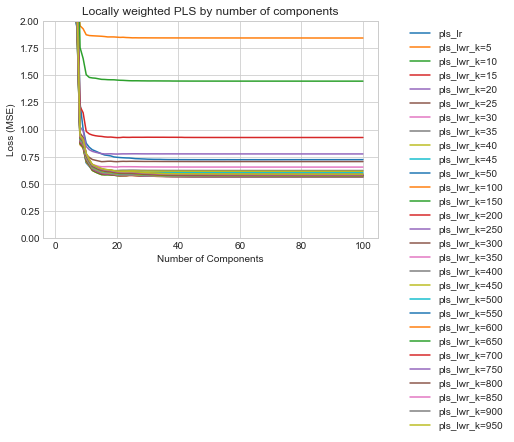

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Locally weighted PLS by number of components")
#ax.plot(x_ls,y_ls,label="lr")

series_labels = scores_df_pls['model'].unique()
for name in series_labels:
    subset = scores_df_pls[scores_df_pls["model"]==name]
    ax.plot(subset["n_comp"],subset["MSE"],label = f"{name}")
ax.set_ylim(0,max_value)
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"mse_plot_pls.png",bbox_inches='tight')

ax.set_ylim(0,2)
plt.savefig(log_dir / f"mse_plot_pls_compressed.png",bbox_inches='tight')


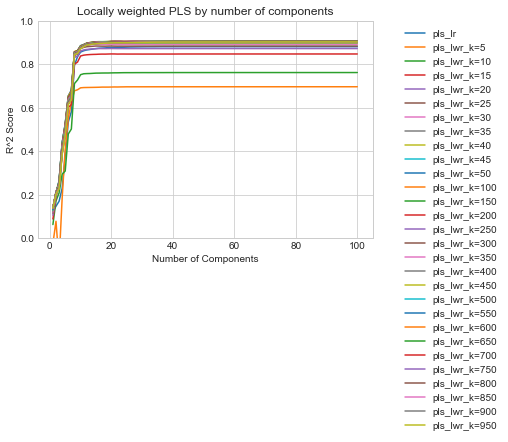

In [17]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("R^2 Score")
ax.set_title("Locally weighted PLS by number of components")

series_labels = scores_df_pls['model'].unique()
for name in series_labels:
    subset = scores_df_pls[scores_df_pls["model"]==name]
    ax.plot(subset["n_comp"],subset["R2"],label = f"{name}")


ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_pls.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_pls_v2.png",bbox_inches='tight')
